# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

  Using cached https://files.pythonhosted.org/packages/01/61/17337866a6e944240c16ab0278a2350fcef57516faef40acbe74824769eb/matplotlib-2.0.2-cp35-cp35m-win_amd64.whl
Found mnist Data
Found celeba Data


Exception:
Traceback (most recent call last):
  File "C:\Users\Filipe\AppData\Local\conda\conda\envs\tens2\lib\site-packages\pip\_internal\basecommand.py", line 228, in main
    status = self.run(options, args)
  File "C:\Users\Filipe\AppData\Local\conda\conda\envs\tens2\lib\site-packages\pip\_internal\commands\install.py", line 291, in run
    resolver.resolve(requirement_set)
  File "C:\Users\Filipe\AppData\Local\conda\conda\envs\tens2\lib\site-packages\pip\_internal\resolve.py", line 103, in resolve
    self._resolve_one(requirement_set, req)
  File "C:\Users\Filipe\AppData\Local\conda\conda\envs\tens2\lib\site-packages\pip\_internal\resolve.py", line 262, in _resolve_one
    check_dist_requires_python(dist)
  File "C:\Users\Filipe\AppData\Local\conda\conda\envs\tens2\lib\site-packages\pip\_internal\utils\packaging.py", line 46, in check_dist_requires_python
    feed_parser.feed(metadata)
  File "C:\Users\Filipe\AppData\Local\conda\conda\envs\tens2\lib\email\feedparser.py", line 178

## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

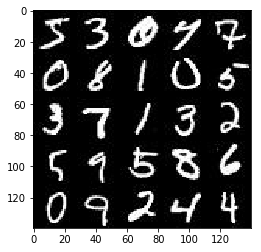

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

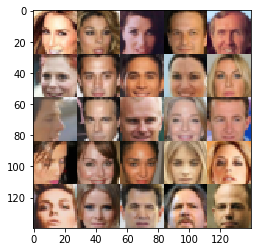

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    img_real = tf.placeholder(tf.float32, shape=[None, image_width, image_height, image_channels])
    z = tf.placeholder(tf.float32, shape=[None, z_dim])
    learning_rate = tf.placeholder(tf.float32)
    return img_real, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
ALPHA = 0.1
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    ## testing the solution used on #DCGAN notebook
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(ALPHA * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(ALPHA * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(ALPHA * bn3, bn3)
        dp3 = tf.nn.dropout(relu3, keep_prob =0.8)

        # 4x4x256

        # Flatten it
        flat = tf.reshape(dp3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits
        


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    ## testing the solution used on #DCGAN notebook

    with tf.variable_scope('generator', reuse=reuse):
        # Fully connected layer
        x1 = tf.layers.dense(z, 7*7*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(ALPHA * x1, x1)
        # 7x7x2048
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.nn.dropout(x2, keep_prob =0.9)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(ALPHA * x2, x2)
        # 14x14x1024 
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding='same')
        x3 = tf.nn.dropout(x3, keep_prob =0.9)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(ALPHA * x3, x3)
        

        # 14x14x512 
        
        x4 = tf.layers.conv2d_transpose(x3, 28, 5, strides=2, padding='same')
        x4 = tf.nn.dropout(x4, keep_prob =0.9)
        x4 = tf.layers.batch_normalization(x4, training=is_train)
        x4 = tf.maximum(ALPHA * x4, x4)
        # 28x28x256 
        
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x4, out_channel_dim, 5, strides=1, padding='same')
        # 28x28xoutdim now
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
smooth = 0.1
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    ## testing the solution used on #DCGAN notebook
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake


    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    ## testing the solution used on #DCGAN notebook
    
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
import pickle as pkl
import matplotlib.pyplot as plt

def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    ## testing the solution used on #DCGAN notebook 
        
    input_real, input_z, learning_r  = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim )
        
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    saver = tf.train.Saver()
    steps = 0
    losses = []
    samples = []
    print_every = 10
    show_every=100
    d_loss_vec = []
    g_loss_vec = []
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                #scale images
                batch_images *= 2
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images})
                
                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))
                    
                    d_loss_vec.append(train_loss_d)
                    g_loss_vec.append(train_loss_g)
                    
                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(input_z, data_shape[3], is_train=False),
                                   feed_dict={input_z: sample_z})
                    samples.append(gen_samples)
                    show_generator_output(sess, 16, input_z, data_shape[3], data_image_mode)


       # saver.save(sess, './checkpoints/generator.ckpt')

    #with open('samples.pkl', 'wb') as f:
        #pkl.dump(samples, f)
        
    Discriminator_loss, = plt.plot(d_loss_vec, color='b', label='Discriminator loss')
    Genereator_loss, = plt.plot(g_loss_vec, color='r', label='Generator loss')
    plt.legend(handles=[ Discriminator_loss, Genereator_loss])
    return losses, samples
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

(60000, 28, 28, 1)
Epoch 1/2... Discriminator Loss: 1.3514... Generator Loss: 10.2370
Epoch 1/2... Discriminator Loss: 1.6448... Generator Loss: 3.7157
Epoch 1/2... Discriminator Loss: 0.9659... Generator Loss: 2.5399
Epoch 1/2... Discriminator Loss: 1.8774... Generator Loss: 2.4164
Epoch 1/2... Discriminator Loss: 1.5619... Generator Loss: 1.6851
Epoch 1/2... Discriminator Loss: 1.6232... Generator Loss: 1.0670
Epoch 1/2... Discriminator Loss: 1.4455... Generator Loss: 0.8366
Epoch 1/2... Discriminator Loss: 1.5667... Generator Loss: 0.5322
Epoch 1/2... Discriminator Loss: 1.5207... Generator Loss: 1.0804
Epoch 1/2... Discriminator Loss: 1.3703... Generator Loss: 1.1273


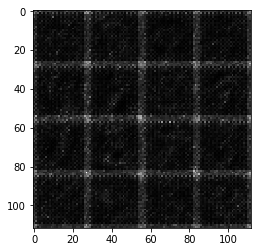

Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 1.0065
Epoch 1/2... Discriminator Loss: 1.4487... Generator Loss: 1.3466
Epoch 1/2... Discriminator Loss: 1.3428... Generator Loss: 1.0104
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 1.5651
Epoch 1/2... Discriminator Loss: 1.3776... Generator Loss: 1.3494
Epoch 1/2... Discriminator Loss: 1.4502... Generator Loss: 1.0688
Epoch 1/2... Discriminator Loss: 1.3366... Generator Loss: 1.2934
Epoch 1/2... Discriminator Loss: 1.2669... Generator Loss: 1.0788
Epoch 1/2... Discriminator Loss: 1.3166... Generator Loss: 1.2548
Epoch 1/2... Discriminator Loss: 1.5210... Generator Loss: 1.4602


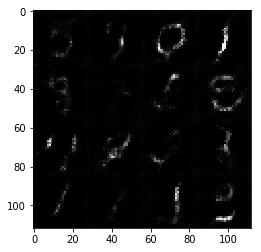

Epoch 1/2... Discriminator Loss: 1.2948... Generator Loss: 1.0536
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 1.1247
Epoch 1/2... Discriminator Loss: 1.2855... Generator Loss: 0.9874
Epoch 1/2... Discriminator Loss: 1.2744... Generator Loss: 0.7738
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 0.6742
Epoch 1/2... Discriminator Loss: 1.3181... Generator Loss: 1.1214
Epoch 1/2... Discriminator Loss: 1.2959... Generator Loss: 1.0033
Epoch 1/2... Discriminator Loss: 1.2443... Generator Loss: 0.8934
Epoch 1/2... Discriminator Loss: 1.2552... Generator Loss: 1.0619
Epoch 1/2... Discriminator Loss: 1.5086... Generator Loss: 0.4581


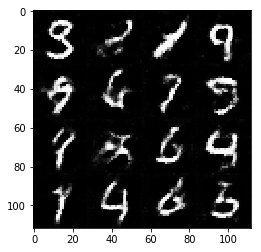

Epoch 1/2... Discriminator Loss: 1.4496... Generator Loss: 0.5333
Epoch 1/2... Discriminator Loss: 1.4469... Generator Loss: 0.5923
Epoch 1/2... Discriminator Loss: 1.2829... Generator Loss: 0.8534
Epoch 1/2... Discriminator Loss: 1.3374... Generator Loss: 0.6314
Epoch 1/2... Discriminator Loss: 1.3199... Generator Loss: 0.8984
Epoch 1/2... Discriminator Loss: 1.3144... Generator Loss: 0.9774
Epoch 1/2... Discriminator Loss: 1.2707... Generator Loss: 1.2984
Epoch 1/2... Discriminator Loss: 1.1896... Generator Loss: 1.0492
Epoch 1/2... Discriminator Loss: 1.7145... Generator Loss: 1.7651
Epoch 1/2... Discriminator Loss: 1.2673... Generator Loss: 1.0528


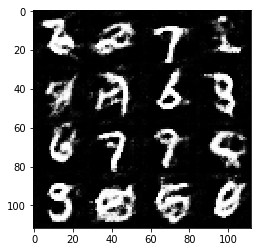

Epoch 1/2... Discriminator Loss: 1.4488... Generator Loss: 1.6955
Epoch 1/2... Discriminator Loss: 1.1401... Generator Loss: 1.1107
Epoch 1/2... Discriminator Loss: 1.5031... Generator Loss: 1.4364
Epoch 1/2... Discriminator Loss: 1.2176... Generator Loss: 0.9254
Epoch 1/2... Discriminator Loss: 1.3132... Generator Loss: 1.1346
Epoch 1/2... Discriminator Loss: 1.3993... Generator Loss: 0.6017
Epoch 2/2... Discriminator Loss: 1.2654... Generator Loss: 1.0224
Epoch 2/2... Discriminator Loss: 1.2553... Generator Loss: 0.8213
Epoch 2/2... Discriminator Loss: 1.3131... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.3285... Generator Loss: 0.6867


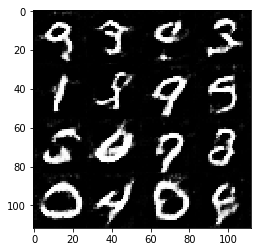

Epoch 2/2... Discriminator Loss: 1.4914... Generator Loss: 0.5828
Epoch 2/2... Discriminator Loss: 1.6372... Generator Loss: 0.4344
Epoch 2/2... Discriminator Loss: 1.2900... Generator Loss: 0.7348
Epoch 2/2... Discriminator Loss: 1.6893... Generator Loss: 0.3822
Epoch 2/2... Discriminator Loss: 1.2205... Generator Loss: 1.0117
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 1.1088
Epoch 2/2... Discriminator Loss: 1.2619... Generator Loss: 1.1307
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 1.1793
Epoch 2/2... Discriminator Loss: 1.2918... Generator Loss: 0.6983
Epoch 2/2... Discriminator Loss: 1.8822... Generator Loss: 0.3107


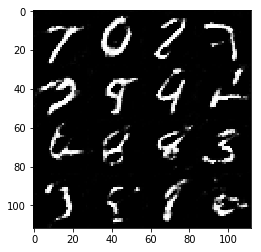

Epoch 2/2... Discriminator Loss: 1.3086... Generator Loss: 0.7503
Epoch 2/2... Discriminator Loss: 1.1985... Generator Loss: 0.7215
Epoch 2/2... Discriminator Loss: 1.5611... Generator Loss: 0.4399
Epoch 2/2... Discriminator Loss: 1.2223... Generator Loss: 1.0806
Epoch 2/2... Discriminator Loss: 1.4149... Generator Loss: 1.6654
Epoch 2/2... Discriminator Loss: 1.3384... Generator Loss: 0.8879
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 1.5757
Epoch 2/2... Discriminator Loss: 1.2507... Generator Loss: 0.8698
Epoch 2/2... Discriminator Loss: 1.1082... Generator Loss: 1.1353
Epoch 2/2... Discriminator Loss: 1.5554... Generator Loss: 0.4420


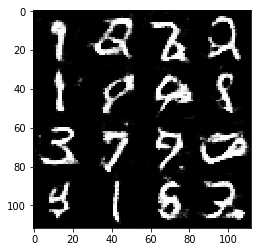

Epoch 2/2... Discriminator Loss: 1.2714... Generator Loss: 0.8448
Epoch 2/2... Discriminator Loss: 1.1378... Generator Loss: 1.1481
Epoch 2/2... Discriminator Loss: 1.3059... Generator Loss: 0.9096
Epoch 2/2... Discriminator Loss: 1.2613... Generator Loss: 0.9856
Epoch 2/2... Discriminator Loss: 1.5140... Generator Loss: 0.4512
Epoch 2/2... Discriminator Loss: 1.1623... Generator Loss: 1.0731
Epoch 2/2... Discriminator Loss: 1.3880... Generator Loss: 0.5810
Epoch 2/2... Discriminator Loss: 1.2669... Generator Loss: 1.0011
Epoch 2/2... Discriminator Loss: 1.5052... Generator Loss: 0.4890
Epoch 2/2... Discriminator Loss: 1.2361... Generator Loss: 1.3028


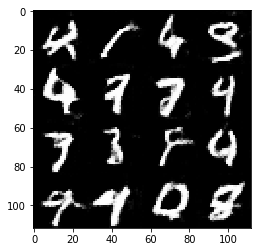

Epoch 2/2... Discriminator Loss: 1.1645... Generator Loss: 1.0804
Epoch 2/2... Discriminator Loss: 1.4786... Generator Loss: 1.3278
Epoch 2/2... Discriminator Loss: 1.1310... Generator Loss: 0.8413
Epoch 2/2... Discriminator Loss: 1.3999... Generator Loss: 1.4806
Epoch 2/2... Discriminator Loss: 1.3602... Generator Loss: 0.5995
Epoch 2/2... Discriminator Loss: 1.3197... Generator Loss: 0.6762
Epoch 2/2... Discriminator Loss: 1.2233... Generator Loss: 0.7252
Epoch 2/2... Discriminator Loss: 1.3370... Generator Loss: 1.1679
Epoch 2/2... Discriminator Loss: 1.2249... Generator Loss: 1.2271
Epoch 2/2... Discriminator Loss: 1.3021... Generator Loss: 1.2613


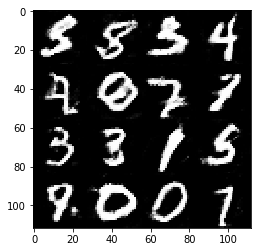

Epoch 2/2... Discriminator Loss: 1.3388... Generator Loss: 0.7637
Epoch 2/2... Discriminator Loss: 1.3512... Generator Loss: 0.6565
Epoch 2/2... Discriminator Loss: 1.4475... Generator Loss: 0.5130


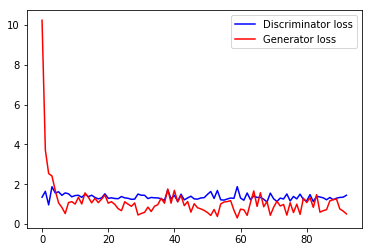

In [35]:
batch_size = 128
z_dim = 200
learning_rate = 0.0006
beta1 = 0.3


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    print(mnist_dataset.shape)
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.8917... Generator Loss: 0.9423
Epoch 1/1... Discriminator Loss: 1.9852... Generator Loss: 0.3431
Epoch 1/1... Discriminator Loss: 1.2102... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 1.1856... Generator Loss: 6.9382
Epoch 1/1... Discriminator Loss: 1.5045... Generator Loss: 0.7906
Epoch 1/1... Discriminator Loss: 4.1997... Generator Loss: 0.0384
Epoch 1/1... Discriminator Loss: 1.2290... Generator Loss: 1.2326
Epoch 1/1... Discriminator Loss: 0.9156... Generator Loss: 1.7961
Epoch 1/1... Discriminator Loss: 0.7891... Generator Loss: 1.8023
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.5705


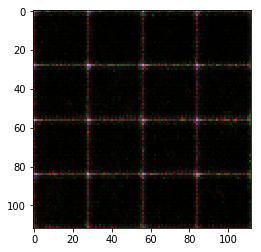

Epoch 1/1... Discriminator Loss: 0.6093... Generator Loss: 1.9510
Epoch 1/1... Discriminator Loss: 1.6287... Generator Loss: 0.5287
Epoch 1/1... Discriminator Loss: 0.6744... Generator Loss: 1.5823
Epoch 1/1... Discriminator Loss: 0.5395... Generator Loss: 1.9793
Epoch 1/1... Discriminator Loss: 0.8906... Generator Loss: 1.1715
Epoch 1/1... Discriminator Loss: 0.7621... Generator Loss: 1.4622
Epoch 1/1... Discriminator Loss: 0.4933... Generator Loss: 3.1279
Epoch 1/1... Discriminator Loss: 1.0475... Generator Loss: 0.8410
Epoch 1/1... Discriminator Loss: 0.5225... Generator Loss: 2.8592
Epoch 1/1... Discriminator Loss: 0.6777... Generator Loss: 1.8592


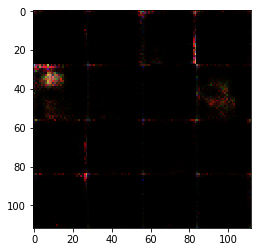

Epoch 1/1... Discriminator Loss: 0.7274... Generator Loss: 1.7170
Epoch 1/1... Discriminator Loss: 0.9212... Generator Loss: 1.3456
Epoch 1/1... Discriminator Loss: 1.7219... Generator Loss: 3.3309
Epoch 1/1... Discriminator Loss: 0.9553... Generator Loss: 1.1640
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.7553
Epoch 1/1... Discriminator Loss: 1.6296... Generator Loss: 0.4107
Epoch 1/1... Discriminator Loss: 0.8779... Generator Loss: 2.4586
Epoch 1/1... Discriminator Loss: 1.0588... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.5784... Generator Loss: 0.5082
Epoch 1/1... Discriminator Loss: 0.9510... Generator Loss: 2.0067


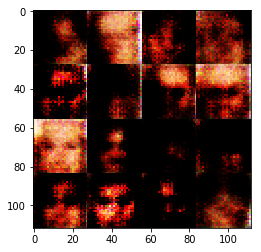

Epoch 1/1... Discriminator Loss: 0.7790... Generator Loss: 1.5372
Epoch 1/1... Discriminator Loss: 0.7552... Generator Loss: 2.8005
Epoch 1/1... Discriminator Loss: 0.8674... Generator Loss: 1.7493
Epoch 1/1... Discriminator Loss: 1.4773... Generator Loss: 0.4730
Epoch 1/1... Discriminator Loss: 1.2450... Generator Loss: 0.9129
Epoch 1/1... Discriminator Loss: 1.4231... Generator Loss: 0.5073
Epoch 1/1... Discriminator Loss: 1.0722... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 0.8676... Generator Loss: 1.2579
Epoch 1/1... Discriminator Loss: 0.7575... Generator Loss: 1.8085
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 1.3284


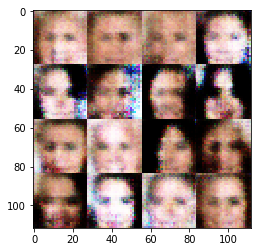

Epoch 1/1... Discriminator Loss: 0.9928... Generator Loss: 0.9667
Epoch 1/1... Discriminator Loss: 0.8739... Generator Loss: 1.2777
Epoch 1/1... Discriminator Loss: 0.6033... Generator Loss: 2.0312
Epoch 1/1... Discriminator Loss: 1.8272... Generator Loss: 0.5602
Epoch 1/1... Discriminator Loss: 0.6695... Generator Loss: 1.9288
Epoch 1/1... Discriminator Loss: 1.1309... Generator Loss: 0.9195
Epoch 1/1... Discriminator Loss: 1.6422... Generator Loss: 0.4437
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.1679
Epoch 1/1... Discriminator Loss: 1.2908... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.8958


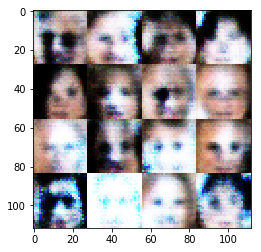

Epoch 1/1... Discriminator Loss: 1.0181... Generator Loss: 1.5043
Epoch 1/1... Discriminator Loss: 1.5622... Generator Loss: 0.7161
Epoch 1/1... Discriminator Loss: 0.8416... Generator Loss: 1.2545
Epoch 1/1... Discriminator Loss: 1.0220... Generator Loss: 0.9325
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.6779
Epoch 1/1... Discriminator Loss: 0.8915... Generator Loss: 1.5315
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.5879
Epoch 1/1... Discriminator Loss: 1.8362... Generator Loss: 0.3549
Epoch 1/1... Discriminator Loss: 1.2487... Generator Loss: 0.8797
Epoch 1/1... Discriminator Loss: 0.9515... Generator Loss: 1.0483


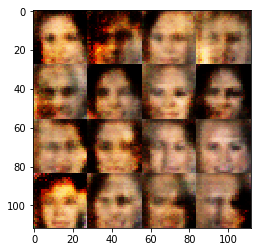

Epoch 1/1... Discriminator Loss: 1.8926... Generator Loss: 0.3807
Epoch 1/1... Discriminator Loss: 1.7220... Generator Loss: 0.3534
Epoch 1/1... Discriminator Loss: 1.0645... Generator Loss: 1.0407
Epoch 1/1... Discriminator Loss: 1.3459... Generator Loss: 0.8021
Epoch 1/1... Discriminator Loss: 1.1987... Generator Loss: 1.6997
Epoch 1/1... Discriminator Loss: 1.0273... Generator Loss: 0.9713
Epoch 1/1... Discriminator Loss: 1.3797... Generator Loss: 0.6579
Epoch 1/1... Discriminator Loss: 1.8493... Generator Loss: 0.2122
Epoch 1/1... Discriminator Loss: 1.0126... Generator Loss: 1.7435
Epoch 1/1... Discriminator Loss: 1.3887... Generator Loss: 1.8276


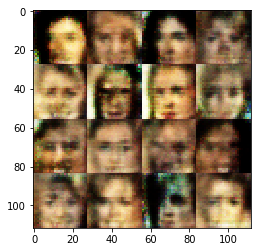

Epoch 1/1... Discriminator Loss: 1.4426... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.0142... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.5162... Generator Loss: 0.4032
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 1.0125
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.8918
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 1.2558... Generator Loss: 1.0239
Epoch 1/1... Discriminator Loss: 1.0969... Generator Loss: 0.9333


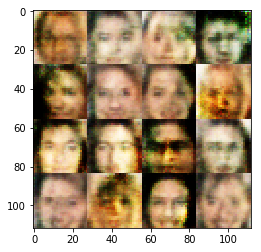

Epoch 1/1... Discriminator Loss: 1.4068... Generator Loss: 0.6202
Epoch 1/1... Discriminator Loss: 1.7351... Generator Loss: 0.3146
Epoch 1/1... Discriminator Loss: 1.6229... Generator Loss: 0.5743
Epoch 1/1... Discriminator Loss: 0.9487... Generator Loss: 1.4249
Epoch 1/1... Discriminator Loss: 1.1908... Generator Loss: 0.7195
Epoch 1/1... Discriminator Loss: 1.2606... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.9086... Generator Loss: 0.2922
Epoch 1/1... Discriminator Loss: 1.3692... Generator Loss: 0.5190
Epoch 1/1... Discriminator Loss: 1.1534... Generator Loss: 0.5426
Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.7055


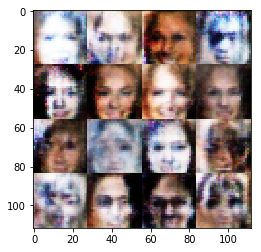

Epoch 1/1... Discriminator Loss: 1.3221... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.5019... Generator Loss: 2.1446
Epoch 1/1... Discriminator Loss: 1.4236... Generator Loss: 0.6996
Epoch 1/1... Discriminator Loss: 1.8499... Generator Loss: 0.3516
Epoch 1/1... Discriminator Loss: 1.2224... Generator Loss: 1.2017
Epoch 1/1... Discriminator Loss: 1.3341... Generator Loss: 0.8460
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6565
Epoch 1/1... Discriminator Loss: 1.4508... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.2818... Generator Loss: 0.9836
Epoch 1/1... Discriminator Loss: 1.2714... Generator Loss: 0.7555


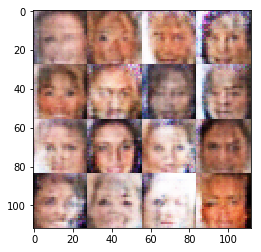

Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.9799
Epoch 1/1... Discriminator Loss: 1.2988... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.3575... Generator Loss: 0.6323
Epoch 1/1... Discriminator Loss: 1.1595... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.3881... Generator Loss: 0.5154
Epoch 1/1... Discriminator Loss: 1.5103... Generator Loss: 0.5969
Epoch 1/1... Discriminator Loss: 1.9296... Generator Loss: 0.3406
Epoch 1/1... Discriminator Loss: 1.5493... Generator Loss: 0.5107
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8384
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.4026


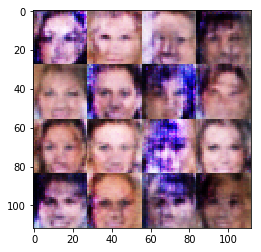

Epoch 1/1... Discriminator Loss: 1.5328... Generator Loss: 0.3427
Epoch 1/1... Discriminator Loss: 1.6265... Generator Loss: 0.3721
Epoch 1/1... Discriminator Loss: 1.6203... Generator Loss: 0.4519
Epoch 1/1... Discriminator Loss: 1.5935... Generator Loss: 0.3698
Epoch 1/1... Discriminator Loss: 1.1842... Generator Loss: 1.4211
Epoch 1/1... Discriminator Loss: 1.5428... Generator Loss: 0.5438
Epoch 1/1... Discriminator Loss: 1.7898... Generator Loss: 0.3589
Epoch 1/1... Discriminator Loss: 1.7295... Generator Loss: 0.3695
Epoch 1/1... Discriminator Loss: 1.5050... Generator Loss: 0.5178
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 1.4637


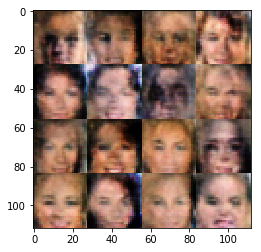

Epoch 1/1... Discriminator Loss: 1.8968... Generator Loss: 0.2766
Epoch 1/1... Discriminator Loss: 1.8934... Generator Loss: 0.2809
Epoch 1/1... Discriminator Loss: 1.1780... Generator Loss: 0.6823
Epoch 1/1... Discriminator Loss: 1.1369... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.0721... Generator Loss: 0.9043
Epoch 1/1... Discriminator Loss: 1.8827... Generator Loss: 0.2492
Epoch 1/1... Discriminator Loss: 1.6329... Generator Loss: 0.5222
Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.5844
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.9568
Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 0.3614


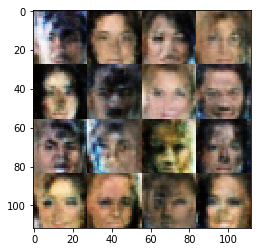

Epoch 1/1... Discriminator Loss: 2.0075... Generator Loss: 0.2651
Epoch 1/1... Discriminator Loss: 1.6728... Generator Loss: 0.4257
Epoch 1/1... Discriminator Loss: 1.1046... Generator Loss: 0.9019
Epoch 1/1... Discriminator Loss: 1.4211... Generator Loss: 0.5479
Epoch 1/1... Discriminator Loss: 1.4164... Generator Loss: 0.5292
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.7021
Epoch 1/1... Discriminator Loss: 1.7697... Generator Loss: 0.2979
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.3544... Generator Loss: 0.6567
Epoch 1/1... Discriminator Loss: 1.3699... Generator Loss: 0.5725


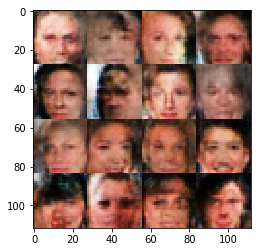

Epoch 1/1... Discriminator Loss: 1.8528... Generator Loss: 0.3536
Epoch 1/1... Discriminator Loss: 1.1446... Generator Loss: 0.7101
Epoch 1/1... Discriminator Loss: 1.3638... Generator Loss: 0.6887
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.7187
Epoch 1/1... Discriminator Loss: 1.7609... Generator Loss: 0.3368
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5825
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 1.6100... Generator Loss: 0.4294
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 2.1693... Generator Loss: 0.2784


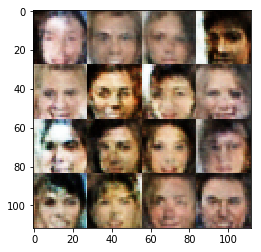

Epoch 1/1... Discriminator Loss: 1.5108... Generator Loss: 0.5779
Epoch 1/1... Discriminator Loss: 1.7776... Generator Loss: 0.3539
Epoch 1/1... Discriminator Loss: 1.5631... Generator Loss: 0.5031
Epoch 1/1... Discriminator Loss: 1.7235... Generator Loss: 0.3837
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 1.3336
Epoch 1/1... Discriminator Loss: 1.2866... Generator Loss: 1.0362
Epoch 1/1... Discriminator Loss: 1.3875... Generator Loss: 0.7119
Epoch 1/1... Discriminator Loss: 1.6616... Generator Loss: 0.2814
Epoch 1/1... Discriminator Loss: 1.1472... Generator Loss: 0.7392
Epoch 1/1... Discriminator Loss: 1.3328... Generator Loss: 0.7269


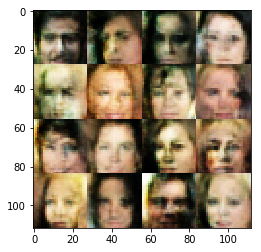

Epoch 1/1... Discriminator Loss: 1.4759... Generator Loss: 0.5091
Epoch 1/1... Discriminator Loss: 1.5357... Generator Loss: 0.5552
Epoch 1/1... Discriminator Loss: 1.3659... Generator Loss: 0.4849
Epoch 1/1... Discriminator Loss: 1.2972... Generator Loss: 0.8674
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.5076
Epoch 1/1... Discriminator Loss: 1.6992... Generator Loss: 0.3778
Epoch 1/1... Discriminator Loss: 1.4989... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.1377... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.4818
Epoch 1/1... Discriminator Loss: 0.9639... Generator Loss: 1.3015


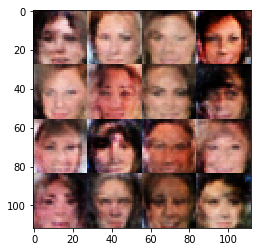

Epoch 1/1... Discriminator Loss: 1.4309... Generator Loss: 0.5027
Epoch 1/1... Discriminator Loss: 1.5712... Generator Loss: 0.6551
Epoch 1/1... Discriminator Loss: 1.6290... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.3316... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.6268... Generator Loss: 0.5108
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.5526
Epoch 1/1... Discriminator Loss: 1.7259... Generator Loss: 0.4155
Epoch 1/1... Discriminator Loss: 0.8924... Generator Loss: 1.4273
Epoch 1/1... Discriminator Loss: 1.8679... Generator Loss: 0.2942
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.7301


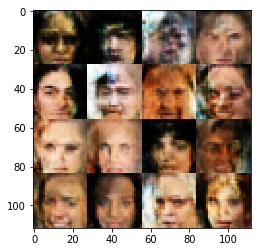

Epoch 1/1... Discriminator Loss: 1.3062... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4102... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.2000... Generator Loss: 0.7083
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.6626
Epoch 1/1... Discriminator Loss: 1.4459... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.6537
Epoch 1/1... Discriminator Loss: 1.6697... Generator Loss: 0.7031
Epoch 1/1... Discriminator Loss: 1.0830... Generator Loss: 0.8507
Epoch 1/1... Discriminator Loss: 1.5385... Generator Loss: 0.3676
Epoch 1/1... Discriminator Loss: 1.0903... Generator Loss: 1.1686


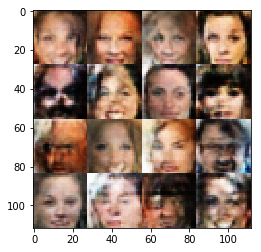

Epoch 1/1... Discriminator Loss: 1.2857... Generator Loss: 0.5345
Epoch 1/1... Discriminator Loss: 1.4564... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 1.5538... Generator Loss: 0.3920
Epoch 1/1... Discriminator Loss: 1.4389... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.8203
Epoch 1/1... Discriminator Loss: 1.6448... Generator Loss: 0.3652
Epoch 1/1... Discriminator Loss: 1.3462... Generator Loss: 0.4827
Epoch 1/1... Discriminator Loss: 1.2123... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.2921... Generator Loss: 0.7888
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.8906


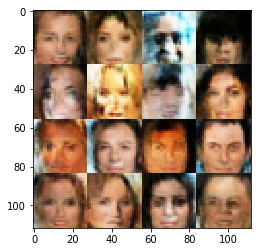

Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5889... Generator Loss: 0.6518
Epoch 1/1... Discriminator Loss: 1.3028... Generator Loss: 0.6842
Epoch 1/1... Discriminator Loss: 1.3792... Generator Loss: 0.8959
Epoch 1/1... Discriminator Loss: 1.2035... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 1.5232... Generator Loss: 0.5777
Epoch 1/1... Discriminator Loss: 1.4410... Generator Loss: 0.6790
Epoch 1/1... Discriminator Loss: 1.4917... Generator Loss: 0.5139
Epoch 1/1... Discriminator Loss: 1.5374... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.7308... Generator Loss: 0.3109


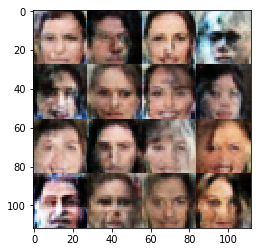

Epoch 1/1... Discriminator Loss: 1.4381... Generator Loss: 0.8305
Epoch 1/1... Discriminator Loss: 1.5392... Generator Loss: 0.4552
Epoch 1/1... Discriminator Loss: 1.5702... Generator Loss: 0.3202
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.7333
Epoch 1/1... Discriminator Loss: 1.4409... Generator Loss: 0.4533
Epoch 1/1... Discriminator Loss: 1.5827... Generator Loss: 0.4758
Epoch 1/1... Discriminator Loss: 1.6875... Generator Loss: 0.8338
Epoch 1/1... Discriminator Loss: 2.0374... Generator Loss: 0.3997
Epoch 1/1... Discriminator Loss: 1.1949... Generator Loss: 0.7946
Epoch 1/1... Discriminator Loss: 1.3866... Generator Loss: 0.4865


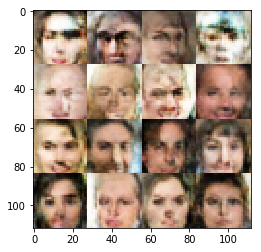

Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.4852
Epoch 1/1... Discriminator Loss: 1.7031... Generator Loss: 0.4304
Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.5508
Epoch 1/1... Discriminator Loss: 1.3840... Generator Loss: 1.0017
Epoch 1/1... Discriminator Loss: 1.4742... Generator Loss: 0.5762
Epoch 1/1... Discriminator Loss: 1.2700... Generator Loss: 0.7117
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.3894
Epoch 1/1... Discriminator Loss: 1.4775... Generator Loss: 0.6983
Epoch 1/1... Discriminator Loss: 1.2640... Generator Loss: 0.7987
Epoch 1/1... Discriminator Loss: 1.7205... Generator Loss: 0.4143


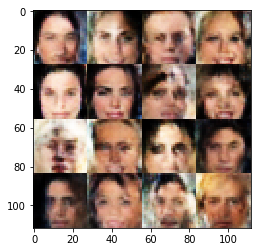

Epoch 1/1... Discriminator Loss: 1.3372... Generator Loss: 0.4237
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.4423
Epoch 1/1... Discriminator Loss: 1.6790... Generator Loss: 0.4005
Epoch 1/1... Discriminator Loss: 1.2830... Generator Loss: 0.6391
Epoch 1/1... Discriminator Loss: 1.1485... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.2822... Generator Loss: 0.7114
Epoch 1/1... Discriminator Loss: 1.2503... Generator Loss: 0.8342
Epoch 1/1... Discriminator Loss: 1.3999... Generator Loss: 0.6284
Epoch 1/1... Discriminator Loss: 1.2300... Generator Loss: 1.0662
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.5705


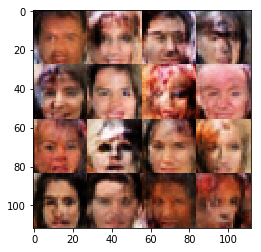

Epoch 1/1... Discriminator Loss: 1.1197... Generator Loss: 0.7226
Epoch 1/1... Discriminator Loss: 1.4447... Generator Loss: 0.4807
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7179
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.5486
Epoch 1/1... Discriminator Loss: 1.5217... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.1805... Generator Loss: 1.1949
Epoch 1/1... Discriminator Loss: 1.8282... Generator Loss: 0.6117
Epoch 1/1... Discriminator Loss: 1.6786... Generator Loss: 0.4793
Epoch 1/1... Discriminator Loss: 1.5654... Generator Loss: 0.7702
Epoch 1/1... Discriminator Loss: 1.3985... Generator Loss: 0.5317


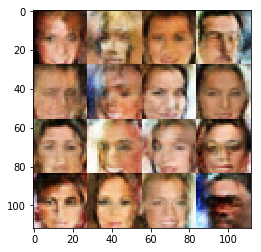

Epoch 1/1... Discriminator Loss: 2.2272... Generator Loss: 0.3785
Epoch 1/1... Discriminator Loss: 1.3438... Generator Loss: 0.5064
Epoch 1/1... Discriminator Loss: 1.4960... Generator Loss: 0.5463
Epoch 1/1... Discriminator Loss: 1.7002... Generator Loss: 0.4361
Epoch 1/1... Discriminator Loss: 1.7357... Generator Loss: 0.3740
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.5741
Epoch 1/1... Discriminator Loss: 1.3498... Generator Loss: 0.7040
Epoch 1/1... Discriminator Loss: 1.4380... Generator Loss: 0.6226
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5443
Epoch 1/1... Discriminator Loss: 1.4696... Generator Loss: 0.5359


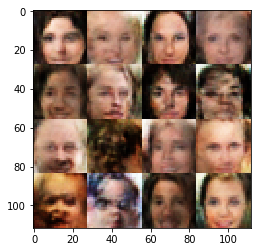

Epoch 1/1... Discriminator Loss: 1.4858... Generator Loss: 0.4707
Epoch 1/1... Discriminator Loss: 1.6285... Generator Loss: 0.5589
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.8337
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.6250
Epoch 1/1... Discriminator Loss: 1.2568... Generator Loss: 0.7248
Epoch 1/1... Discriminator Loss: 1.4694... Generator Loss: 0.4463
Epoch 1/1... Discriminator Loss: 1.4868... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.5016... Generator Loss: 0.5147
Epoch 1/1... Discriminator Loss: 1.5722... Generator Loss: 0.4622
Epoch 1/1... Discriminator Loss: 1.6319... Generator Loss: 0.5171


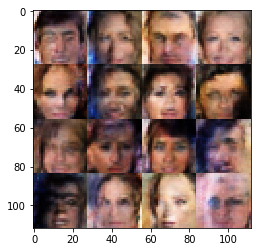

Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.8151
Epoch 1/1... Discriminator Loss: 1.7032... Generator Loss: 0.4981
Epoch 1/1... Discriminator Loss: 1.5446... Generator Loss: 0.4701
Epoch 1/1... Discriminator Loss: 1.0744... Generator Loss: 0.9084
Epoch 1/1... Discriminator Loss: 1.7453... Generator Loss: 0.3753
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.8048
Epoch 1/1... Discriminator Loss: 1.4713... Generator Loss: 0.6147
Epoch 1/1... Discriminator Loss: 1.4689... Generator Loss: 0.4831
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.6009
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.7289


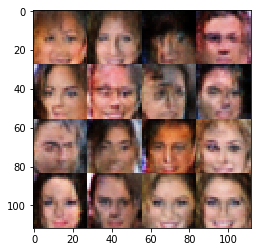

Epoch 1/1... Discriminator Loss: 1.1963... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.6806... Generator Loss: 0.3689
Epoch 1/1... Discriminator Loss: 1.4667... Generator Loss: 0.4460
Epoch 1/1... Discriminator Loss: 1.7333... Generator Loss: 0.3149
Epoch 1/1... Discriminator Loss: 1.7897... Generator Loss: 0.3058
Epoch 1/1... Discriminator Loss: 1.5216... Generator Loss: 0.6021
Epoch 1/1... Discriminator Loss: 1.6715... Generator Loss: 0.3918
Epoch 1/1... Discriminator Loss: 1.7203... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.4741... Generator Loss: 0.6051
Epoch 1/1... Discriminator Loss: 1.6091... Generator Loss: 0.4127


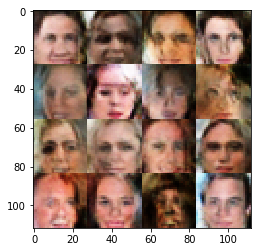

Epoch 1/1... Discriminator Loss: 1.7415... Generator Loss: 0.3967
Epoch 1/1... Discriminator Loss: 1.6875... Generator Loss: 0.5193
Epoch 1/1... Discriminator Loss: 1.7146... Generator Loss: 0.3645
Epoch 1/1... Discriminator Loss: 1.5100... Generator Loss: 0.4708
Epoch 1/1... Discriminator Loss: 1.6141... Generator Loss: 0.5336
Epoch 1/1... Discriminator Loss: 1.3625... Generator Loss: 0.6945
Epoch 1/1... Discriminator Loss: 1.8355... Generator Loss: 0.3456
Epoch 1/1... Discriminator Loss: 1.8102... Generator Loss: 0.3378
Epoch 1/1... Discriminator Loss: 1.5405... Generator Loss: 0.5545
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.8709


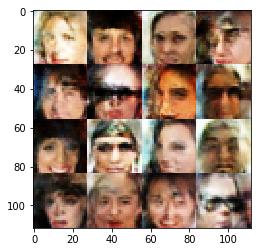

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.6133
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.7294... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 1.8600... Generator Loss: 0.3322
Epoch 1/1... Discriminator Loss: 1.4154... Generator Loss: 0.4709
Epoch 1/1... Discriminator Loss: 1.3760... Generator Loss: 0.6318
Epoch 1/1... Discriminator Loss: 1.5596... Generator Loss: 0.5931
Epoch 1/1... Discriminator Loss: 1.5591... Generator Loss: 0.4844
Epoch 1/1... Discriminator Loss: 1.8179... Generator Loss: 0.3175
Epoch 1/1... Discriminator Loss: 1.5756... Generator Loss: 0.3867


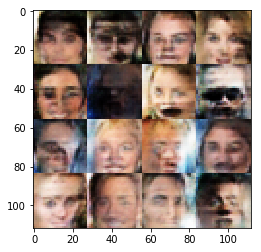

Epoch 1/1... Discriminator Loss: 1.5376... Generator Loss: 0.4218
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.5746
Epoch 1/1... Discriminator Loss: 1.3565... Generator Loss: 0.6306
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.5150
Epoch 1/1... Discriminator Loss: 1.3869... Generator Loss: 0.5202
Epoch 1/1... Discriminator Loss: 1.4265... Generator Loss: 0.5435
Epoch 1/1... Discriminator Loss: 1.8862... Generator Loss: 0.3726
Epoch 1/1... Discriminator Loss: 1.5009... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.6220... Generator Loss: 0.5130
Epoch 1/1... Discriminator Loss: 1.1728... Generator Loss: 0.8027


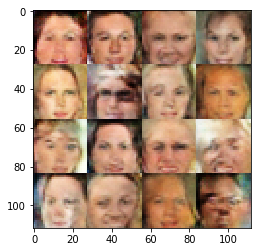

Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.7467
Epoch 1/1... Discriminator Loss: 1.8850... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.5188... Generator Loss: 0.4266
Epoch 1/1... Discriminator Loss: 1.3130... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.4618
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.4551
Epoch 1/1... Discriminator Loss: 1.5353... Generator Loss: 0.4889
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.4430... Generator Loss: 0.5712
Epoch 1/1... Discriminator Loss: 1.6269... Generator Loss: 0.5485


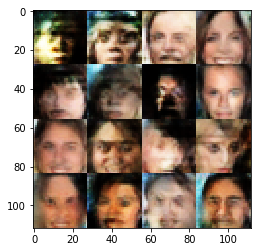

Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 0.4317
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6691
Epoch 1/1... Discriminator Loss: 1.6401... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.4983... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.4012... Generator Loss: 0.6146
Epoch 1/1... Discriminator Loss: 1.2876... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.4241... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.6043... Generator Loss: 0.3856
Epoch 1/1... Discriminator Loss: 1.6736... Generator Loss: 0.4106


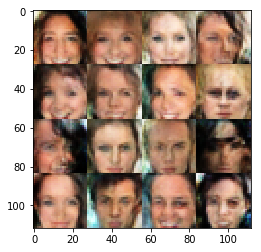

Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.5410
Epoch 1/1... Discriminator Loss: 1.9988... Generator Loss: 0.2699
Epoch 1/1... Discriminator Loss: 1.1707... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.7025... Generator Loss: 0.3728
Epoch 1/1... Discriminator Loss: 1.3564... Generator Loss: 0.5679
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7060
Epoch 1/1... Discriminator Loss: 1.1660... Generator Loss: 0.8397
Epoch 1/1... Discriminator Loss: 1.4702... Generator Loss: 0.5313
Epoch 1/1... Discriminator Loss: 1.3609... Generator Loss: 0.5721
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.5600


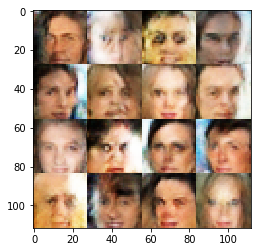

Epoch 1/1... Discriminator Loss: 1.1170... Generator Loss: 0.7886
Epoch 1/1... Discriminator Loss: 1.6193... Generator Loss: 0.3731
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.5320
Epoch 1/1... Discriminator Loss: 1.4940... Generator Loss: 0.4047
Epoch 1/1... Discriminator Loss: 1.5322... Generator Loss: 0.4277
Epoch 1/1... Discriminator Loss: 1.4424... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.4031... Generator Loss: 0.5315
Epoch 1/1... Discriminator Loss: 1.6503... Generator Loss: 0.4862
Epoch 1/1... Discriminator Loss: 1.6571... Generator Loss: 0.6457
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.3957


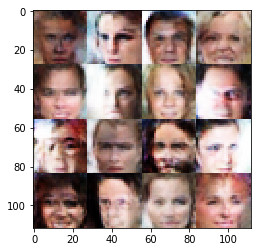

Epoch 1/1... Discriminator Loss: 1.3292... Generator Loss: 0.6143
Epoch 1/1... Discriminator Loss: 1.2758... Generator Loss: 0.7211
Epoch 1/1... Discriminator Loss: 1.8248... Generator Loss: 0.4135
Epoch 1/1... Discriminator Loss: 1.2634... Generator Loss: 0.6720
Epoch 1/1... Discriminator Loss: 1.5876... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.2095... Generator Loss: 0.7325
Epoch 1/1... Discriminator Loss: 1.3603... Generator Loss: 0.5084
Epoch 1/1... Discriminator Loss: 1.6081... Generator Loss: 0.4570
Epoch 1/1... Discriminator Loss: 1.6487... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6519


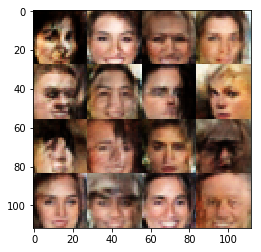

Epoch 1/1... Discriminator Loss: 1.3165... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 0.9957... Generator Loss: 1.0269
Epoch 1/1... Discriminator Loss: 1.2477... Generator Loss: 0.9430
Epoch 1/1... Discriminator Loss: 1.7021... Generator Loss: 0.4200
Epoch 1/1... Discriminator Loss: 1.2729... Generator Loss: 0.6120
Epoch 1/1... Discriminator Loss: 1.5002... Generator Loss: 0.4912
Epoch 1/1... Discriminator Loss: 1.1861... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.4672... Generator Loss: 0.4754
Epoch 1/1... Discriminator Loss: 1.6146... Generator Loss: 0.4750
Epoch 1/1... Discriminator Loss: 1.5469... Generator Loss: 0.4751


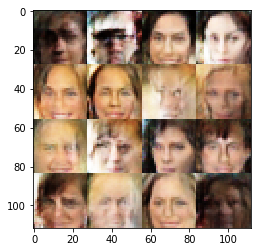

Epoch 1/1... Discriminator Loss: 1.4781... Generator Loss: 0.5321
Epoch 1/1... Discriminator Loss: 1.3454... Generator Loss: 0.7601
Epoch 1/1... Discriminator Loss: 1.7172... Generator Loss: 0.4531
Epoch 1/1... Discriminator Loss: 1.4900... Generator Loss: 0.5271
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.5768
Epoch 1/1... Discriminator Loss: 1.6816... Generator Loss: 0.3745
Epoch 1/1... Discriminator Loss: 1.3488... Generator Loss: 0.6697
Epoch 1/1... Discriminator Loss: 1.5689... Generator Loss: 0.3214
Epoch 1/1... Discriminator Loss: 1.5239... Generator Loss: 0.4314
Epoch 1/1... Discriminator Loss: 1.3449... Generator Loss: 0.6408


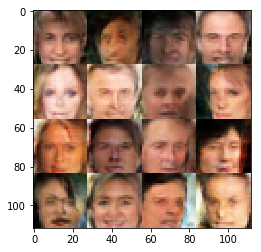

Epoch 1/1... Discriminator Loss: 1.5647... Generator Loss: 0.6398
Epoch 1/1... Discriminator Loss: 1.4849... Generator Loss: 0.4603
Epoch 1/1... Discriminator Loss: 1.4369... Generator Loss: 0.4804
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.4540... Generator Loss: 0.5282
Epoch 1/1... Discriminator Loss: 1.3648... Generator Loss: 0.4792
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.7035
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.5533
Epoch 1/1... Discriminator Loss: 2.0969... Generator Loss: 0.2838
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.5135


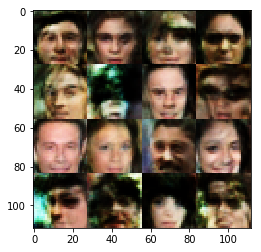

Epoch 1/1... Discriminator Loss: 1.2623... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.3815
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.9232
Epoch 1/1... Discriminator Loss: 1.4722... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 1.4212... Generator Loss: 0.5452
Epoch 1/1... Discriminator Loss: 1.2877... Generator Loss: 0.7950
Epoch 1/1... Discriminator Loss: 1.4209... Generator Loss: 0.5254
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.4421
Epoch 1/1... Discriminator Loss: 1.3141... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 0.5496


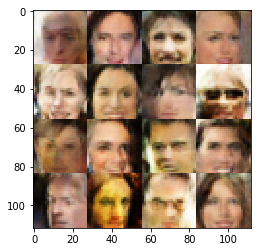

Epoch 1/1... Discriminator Loss: 1.1421... Generator Loss: 0.7776
Epoch 1/1... Discriminator Loss: 1.6282... Generator Loss: 0.5115
Epoch 1/1... Discriminator Loss: 1.2138... Generator Loss: 0.6330
Epoch 1/1... Discriminator Loss: 1.4352... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.5196... Generator Loss: 0.6650
Epoch 1/1... Discriminator Loss: 1.5440... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.3718... Generator Loss: 0.4704
Epoch 1/1... Discriminator Loss: 1.3082... Generator Loss: 0.5734
Epoch 1/1... Discriminator Loss: 1.4642... Generator Loss: 0.7104
Epoch 1/1... Discriminator Loss: 1.2940... Generator Loss: 0.8685


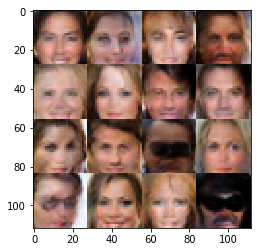

Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.6335
Epoch 1/1... Discriminator Loss: 1.2539... Generator Loss: 0.8193
Epoch 1/1... Discriminator Loss: 1.2110... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 1.5938... Generator Loss: 0.3812
Epoch 1/1... Discriminator Loss: 1.5080... Generator Loss: 0.4871
Epoch 1/1... Discriminator Loss: 1.1276... Generator Loss: 0.9072
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6513
Epoch 1/1... Discriminator Loss: 1.2081... Generator Loss: 0.7127
Epoch 1/1... Discriminator Loss: 1.8917... Generator Loss: 0.2670
Epoch 1/1... Discriminator Loss: 1.3224... Generator Loss: 0.8523


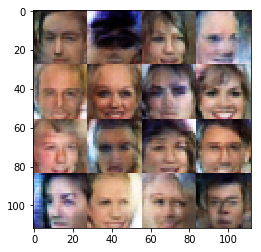

Epoch 1/1... Discriminator Loss: 1.4939... Generator Loss: 0.6910
Epoch 1/1... Discriminator Loss: 1.5420... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 1.3057... Generator Loss: 0.6754
Epoch 1/1... Discriminator Loss: 1.2677... Generator Loss: 0.8164
Epoch 1/1... Discriminator Loss: 1.1312... Generator Loss: 0.8884
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.8570... Generator Loss: 0.4626
Epoch 1/1... Discriminator Loss: 1.4790... Generator Loss: 0.5020
Epoch 1/1... Discriminator Loss: 1.4638... Generator Loss: 0.5664
Epoch 1/1... Discriminator Loss: 1.4013... Generator Loss: 0.6933


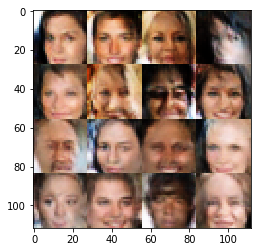

Epoch 1/1... Discriminator Loss: 1.7398... Generator Loss: 0.5843
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.5317
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.4333... Generator Loss: 0.6337
Epoch 1/1... Discriminator Loss: 1.2716... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.9130
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.5569
Epoch 1/1... Discriminator Loss: 1.4552... Generator Loss: 0.6662
Epoch 1/1... Discriminator Loss: 1.5180... Generator Loss: 0.5559
Epoch 1/1... Discriminator Loss: 1.3358... Generator Loss: 0.5185


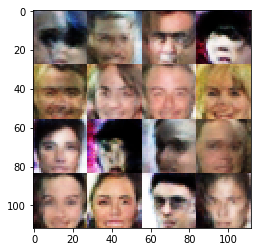

Epoch 1/1... Discriminator Loss: 1.5485... Generator Loss: 0.4058
Epoch 1/1... Discriminator Loss: 1.4473... Generator Loss: 0.6314
Epoch 1/1... Discriminator Loss: 1.2856... Generator Loss: 0.8763
Epoch 1/1... Discriminator Loss: 1.1333... Generator Loss: 0.6991
Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4338... Generator Loss: 0.5004
Epoch 1/1... Discriminator Loss: 1.2980... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.3816... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.6550
Epoch 1/1... Discriminator Loss: 1.2864... Generator Loss: 0.7632


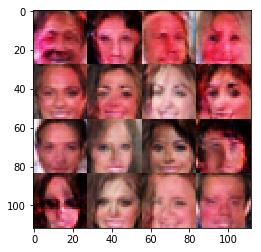

Epoch 1/1... Discriminator Loss: 2.0873... Generator Loss: 0.2905
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.6445
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.5875
Epoch 1/1... Discriminator Loss: 1.6998... Generator Loss: 0.3859
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.6719
Epoch 1/1... Discriminator Loss: 1.3250... Generator Loss: 0.6986
Epoch 1/1... Discriminator Loss: 1.6432... Generator Loss: 0.5208
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.4435
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.6450
Epoch 1/1... Discriminator Loss: 1.2341... Generator Loss: 0.7972


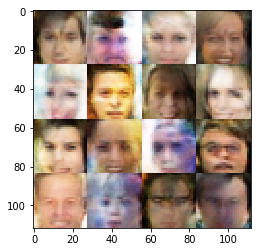

Epoch 1/1... Discriminator Loss: 1.2971... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.7545
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6141
Epoch 1/1... Discriminator Loss: 0.8881... Generator Loss: 1.0370
Epoch 1/1... Discriminator Loss: 1.7449... Generator Loss: 0.4705
Epoch 1/1... Discriminator Loss: 1.5514... Generator Loss: 0.5263
Epoch 1/1... Discriminator Loss: 1.2570... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.6182... Generator Loss: 0.3818
Epoch 1/1... Discriminator Loss: 1.2483... Generator Loss: 0.7709


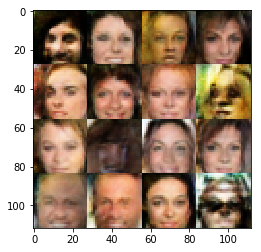

Epoch 1/1... Discriminator Loss: 1.1985... Generator Loss: 0.7330
Epoch 1/1... Discriminator Loss: 1.2451... Generator Loss: 0.8627
Epoch 1/1... Discriminator Loss: 1.3873... Generator Loss: 0.6424
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.9790
Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6258
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.5089
Epoch 1/1... Discriminator Loss: 1.4544... Generator Loss: 0.5299
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.5950
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6383
Epoch 1/1... Discriminator Loss: 1.3437... Generator Loss: 0.6340


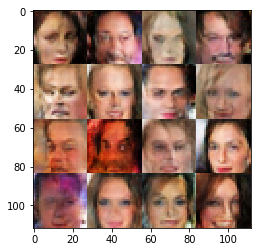

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3628... Generator Loss: 0.6519
Epoch 1/1... Discriminator Loss: 1.3115... Generator Loss: 0.7107
Epoch 1/1... Discriminator Loss: 1.2795... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.5824
Epoch 1/1... Discriminator Loss: 1.4449... Generator Loss: 0.5608
Epoch 1/1... Discriminator Loss: 1.5024... Generator Loss: 0.4280
Epoch 1/1... Discriminator Loss: 1.4818... Generator Loss: 0.4878
Epoch 1/1... Discriminator Loss: 1.6201... Generator Loss: 0.5799


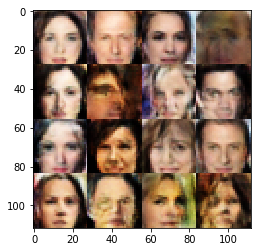

Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.5337
Epoch 1/1... Discriminator Loss: 1.2773... Generator Loss: 0.8376
Epoch 1/1... Discriminator Loss: 1.3407... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.8296... Generator Loss: 0.4690
Epoch 1/1... Discriminator Loss: 1.2622... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2712... Generator Loss: 0.8680
Epoch 1/1... Discriminator Loss: 1.5213... Generator Loss: 0.5065
Epoch 1/1... Discriminator Loss: 1.3469... Generator Loss: 0.7371
Epoch 1/1... Discriminator Loss: 1.5504... Generator Loss: 0.5522
Epoch 1/1... Discriminator Loss: 1.2382... Generator Loss: 0.6501


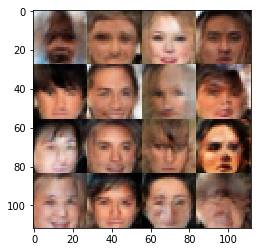

Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.3122... Generator Loss: 0.6197
Epoch 1/1... Discriminator Loss: 1.0963... Generator Loss: 0.9409
Epoch 1/1... Discriminator Loss: 1.1877... Generator Loss: 0.7110
Epoch 1/1... Discriminator Loss: 1.5467... Generator Loss: 0.5812
Epoch 1/1... Discriminator Loss: 1.3309... Generator Loss: 0.6600
Epoch 1/1... Discriminator Loss: 1.3269... Generator Loss: 0.8239
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.2845... Generator Loss: 0.6747
Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.6211


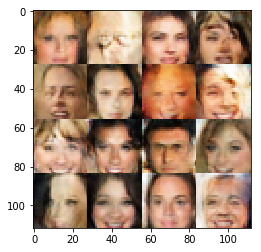

Epoch 1/1... Discriminator Loss: 1.4131... Generator Loss: 0.5295
Epoch 1/1... Discriminator Loss: 1.6475... Generator Loss: 0.4560
Epoch 1/1... Discriminator Loss: 1.6399... Generator Loss: 0.5723
Epoch 1/1... Discriminator Loss: 1.4240... Generator Loss: 0.6894
Epoch 1/1... Discriminator Loss: 1.4640... Generator Loss: 0.4923
Epoch 1/1... Discriminator Loss: 1.1186... Generator Loss: 0.7691
Epoch 1/1... Discriminator Loss: 1.6192... Generator Loss: 0.5289
Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.4520... Generator Loss: 0.6027


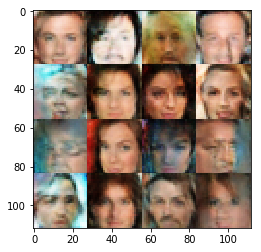

Epoch 1/1... Discriminator Loss: 1.2981... Generator Loss: 0.6980
Epoch 1/1... Discriminator Loss: 1.8009... Generator Loss: 0.4380
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 0.6193
Epoch 1/1... Discriminator Loss: 1.6111... Generator Loss: 0.4196
Epoch 1/1... Discriminator Loss: 1.1183... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.5891... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.2541... Generator Loss: 0.7280
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.6329
Epoch 1/1... Discriminator Loss: 1.1855... Generator Loss: 0.8438
Epoch 1/1... Discriminator Loss: 1.5489... Generator Loss: 0.5558


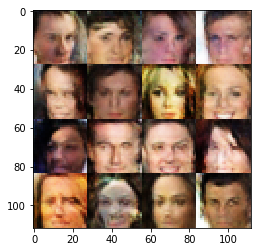

Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.7124
Epoch 1/1... Discriminator Loss: 1.4635... Generator Loss: 0.6077
Epoch 1/1... Discriminator Loss: 1.3223... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3289... Generator Loss: 0.7249
Epoch 1/1... Discriminator Loss: 1.4502... Generator Loss: 0.7314
Epoch 1/1... Discriminator Loss: 1.2004... Generator Loss: 0.6501
Epoch 1/1... Discriminator Loss: 1.3135... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.5494... Generator Loss: 0.4231
Epoch 1/1... Discriminator Loss: 1.1053... Generator Loss: 0.8316


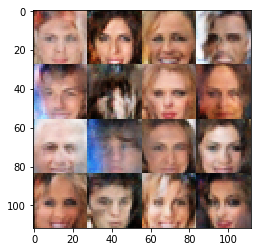

Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.7980
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5293
Epoch 1/1... Discriminator Loss: 1.5460... Generator Loss: 0.4543
Epoch 1/1... Discriminator Loss: 1.4468... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.6007... Generator Loss: 0.4078
Epoch 1/1... Discriminator Loss: 1.4398... Generator Loss: 0.6636
Epoch 1/1... Discriminator Loss: 1.4982... Generator Loss: 0.5168
Epoch 1/1... Discriminator Loss: 1.7255... Generator Loss: 0.4404
Epoch 1/1... Discriminator Loss: 1.8027... Generator Loss: 0.5083
Epoch 1/1... Discriminator Loss: 1.4066... Generator Loss: 0.5385


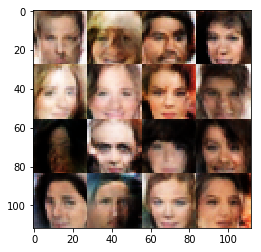

Epoch 1/1... Discriminator Loss: 1.5222... Generator Loss: 0.4554
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.7356
Epoch 1/1... Discriminator Loss: 1.3790... Generator Loss: 0.5209
Epoch 1/1... Discriminator Loss: 1.0861... Generator Loss: 0.8694
Epoch 1/1... Discriminator Loss: 1.5133... Generator Loss: 0.4927
Epoch 1/1... Discriminator Loss: 1.4979... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.5366... Generator Loss: 0.5037
Epoch 1/1... Discriminator Loss: 1.3119... Generator Loss: 0.5944
Epoch 1/1... Discriminator Loss: 1.5323... Generator Loss: 0.5159
Epoch 1/1... Discriminator Loss: 1.4949... Generator Loss: 0.5417


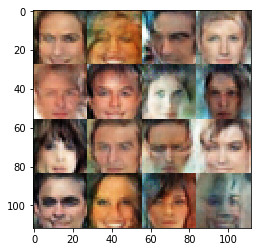

Epoch 1/1... Discriminator Loss: 1.6036... Generator Loss: 0.4544
Epoch 1/1... Discriminator Loss: 1.1718... Generator Loss: 0.8332
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6977
Epoch 1/1... Discriminator Loss: 1.3844... Generator Loss: 0.6953
Epoch 1/1... Discriminator Loss: 1.3734... Generator Loss: 0.5640
Epoch 1/1... Discriminator Loss: 1.4978... Generator Loss: 0.4685
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.9566
Epoch 1/1... Discriminator Loss: 1.2484... Generator Loss: 0.8504
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6322
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.8511


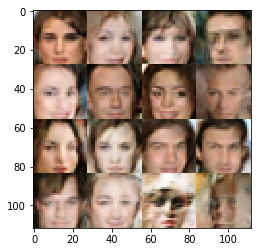

Epoch 1/1... Discriminator Loss: 1.3749... Generator Loss: 0.5291
Epoch 1/1... Discriminator Loss: 1.1521... Generator Loss: 0.8009
Epoch 1/1... Discriminator Loss: 1.3133... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.2848... Generator Loss: 0.5298
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.9828
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4760... Generator Loss: 0.5383
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 0.7914
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8798


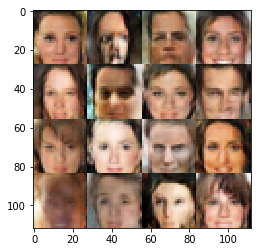

Epoch 1/1... Discriminator Loss: 1.6505... Generator Loss: 0.4865
Epoch 1/1... Discriminator Loss: 1.2401... Generator Loss: 0.6939
Epoch 1/1... Discriminator Loss: 1.1809... Generator Loss: 0.6926
Epoch 1/1... Discriminator Loss: 1.2379... Generator Loss: 0.7276
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6735
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.8022
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.7344
Epoch 1/1... Discriminator Loss: 1.6582... Generator Loss: 0.4271
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.6819
Epoch 1/1... Discriminator Loss: 1.2428... Generator Loss: 0.5202


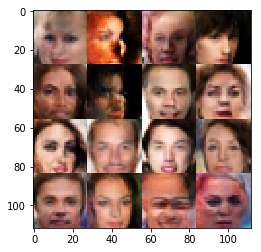

Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6465
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.6222... Generator Loss: 0.5369
Epoch 1/1... Discriminator Loss: 1.3698... Generator Loss: 0.6477
Epoch 1/1... Discriminator Loss: 1.5708... Generator Loss: 0.5112
Epoch 1/1... Discriminator Loss: 1.3192... Generator Loss: 0.5893
Epoch 1/1... Discriminator Loss: 1.4474... Generator Loss: 0.5913
Epoch 1/1... Discriminator Loss: 1.4643... Generator Loss: 0.7004
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.5469
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.8061


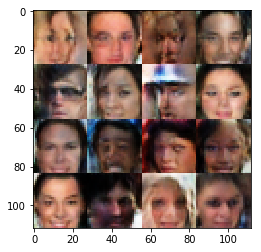

Epoch 1/1... Discriminator Loss: 1.2817... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.7764
Epoch 1/1... Discriminator Loss: 1.2791... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4776... Generator Loss: 0.5488
Epoch 1/1... Discriminator Loss: 1.6331... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.2387... Generator Loss: 0.7016
Epoch 1/1... Discriminator Loss: 1.3691... Generator Loss: 0.5891
Epoch 1/1... Discriminator Loss: 1.3147... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.4024... Generator Loss: 0.5446
Epoch 1/1... Discriminator Loss: 1.4356... Generator Loss: 0.6980


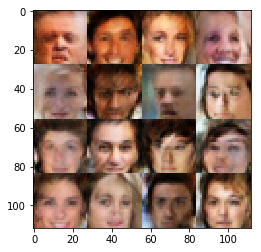

Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 0.8861
Epoch 1/1... Discriminator Loss: 1.2604... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.2882... Generator Loss: 0.6342
Epoch 1/1... Discriminator Loss: 1.4244... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.1997... Generator Loss: 0.7159
Epoch 1/1... Discriminator Loss: 1.4018... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.0339... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.1808... Generator Loss: 0.8118
Epoch 1/1... Discriminator Loss: 1.1790... Generator Loss: 0.8317
Epoch 1/1... Discriminator Loss: 1.3201... Generator Loss: 0.6910


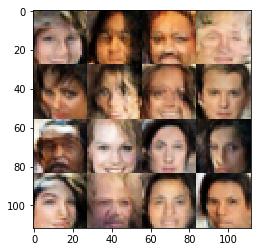

Epoch 1/1... Discriminator Loss: 1.2654... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.2179... Generator Loss: 0.6483
Epoch 1/1... Discriminator Loss: 1.1494... Generator Loss: 0.9340
Epoch 1/1... Discriminator Loss: 1.1557... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.6387
Epoch 1/1... Discriminator Loss: 1.6822... Generator Loss: 0.5128
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 1.6018... Generator Loss: 0.5288
Epoch 1/1... Discriminator Loss: 1.2701... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.7465... Generator Loss: 0.4299


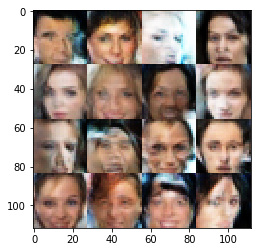

Epoch 1/1... Discriminator Loss: 1.2812... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.1640... Generator Loss: 0.6710
Epoch 1/1... Discriminator Loss: 1.2423... Generator Loss: 0.7229
Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.6048
Epoch 1/1... Discriminator Loss: 1.3910... Generator Loss: 0.8002
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.8796
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.7318
Epoch 1/1... Discriminator Loss: 1.3931... Generator Loss: 0.8808
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.8219


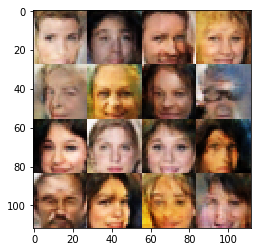

Epoch 1/1... Discriminator Loss: 1.2585... Generator Loss: 0.9925
Epoch 1/1... Discriminator Loss: 1.2665... Generator Loss: 0.6230
Epoch 1/1... Discriminator Loss: 1.3148... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.2153... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.2548... Generator Loss: 0.8546
Epoch 1/1... Discriminator Loss: 1.3926... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.4281... Generator Loss: 0.6486
Epoch 1/1... Discriminator Loss: 1.3049... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.7522
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7081


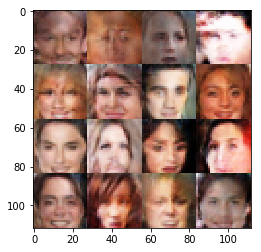

Epoch 1/1... Discriminator Loss: 1.5431... Generator Loss: 0.5028
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.5963
Epoch 1/1... Discriminator Loss: 1.4788... Generator Loss: 0.4511
Epoch 1/1... Discriminator Loss: 1.5290... Generator Loss: 0.5270
Epoch 1/1... Discriminator Loss: 1.2739... Generator Loss: 0.8319
Epoch 1/1... Discriminator Loss: 1.6483... Generator Loss: 0.5685
Epoch 1/1... Discriminator Loss: 1.3382... Generator Loss: 0.6933
Epoch 1/1... Discriminator Loss: 1.4032... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.3194... Generator Loss: 0.8676
Epoch 1/1... Discriminator Loss: 1.3039... Generator Loss: 0.7939


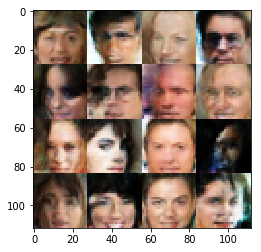

Epoch 1/1... Discriminator Loss: 1.2096... Generator Loss: 0.6901
Epoch 1/1... Discriminator Loss: 1.4814... Generator Loss: 0.5706
Epoch 1/1... Discriminator Loss: 1.1881... Generator Loss: 0.9217
Epoch 1/1... Discriminator Loss: 1.4385... Generator Loss: 0.5635
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.3655... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.6692
Epoch 1/1... Discriminator Loss: 1.6569... Generator Loss: 0.3924
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.7024
Epoch 1/1... Discriminator Loss: 1.2322... Generator Loss: 0.7541


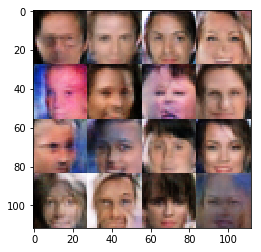

Epoch 1/1... Discriminator Loss: 1.5346... Generator Loss: 0.6259
Epoch 1/1... Discriminator Loss: 1.2690... Generator Loss: 0.7782
Epoch 1/1... Discriminator Loss: 1.3586... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 1.4666... Generator Loss: 0.8360
Epoch 1/1... Discriminator Loss: 1.2669... Generator Loss: 0.7583
Epoch 1/1... Discriminator Loss: 1.4346... Generator Loss: 0.6942
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 1.0396
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7345
Epoch 1/1... Discriminator Loss: 1.5247... Generator Loss: 0.6352


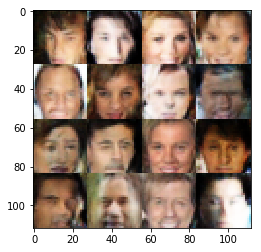

Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.0775
Epoch 1/1... Discriminator Loss: 1.2698... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.1327... Generator Loss: 0.8079
Epoch 1/1... Discriminator Loss: 1.7645... Generator Loss: 0.4286
Epoch 1/1... Discriminator Loss: 1.5193... Generator Loss: 0.5516
Epoch 1/1... Discriminator Loss: 1.2162... Generator Loss: 0.9956
Epoch 1/1... Discriminator Loss: 1.4591... Generator Loss: 0.6106
Epoch 1/1... Discriminator Loss: 1.4928... Generator Loss: 0.6173
Epoch 1/1... Discriminator Loss: 1.2395... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.3432... Generator Loss: 0.6706


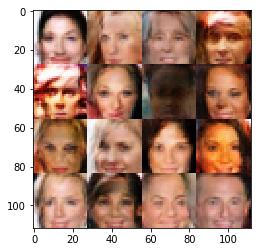

Epoch 1/1... Discriminator Loss: 1.3025... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.1612... Generator Loss: 0.7350
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.4311... Generator Loss: 0.5450
Epoch 1/1... Discriminator Loss: 1.3261... Generator Loss: 0.6539
Epoch 1/1... Discriminator Loss: 1.3381... Generator Loss: 0.5484
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.3639... Generator Loss: 0.4859
Epoch 1/1... Discriminator Loss: 1.0923... Generator Loss: 0.8295
Epoch 1/1... Discriminator Loss: 1.2287... Generator Loss: 0.6812


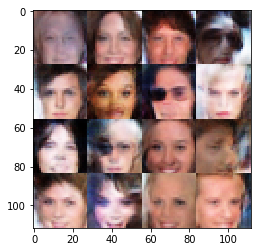

Epoch 1/1... Discriminator Loss: 1.2489... Generator Loss: 0.6707
Epoch 1/1... Discriminator Loss: 1.3512... Generator Loss: 0.5732
Epoch 1/1... Discriminator Loss: 1.5510... Generator Loss: 0.4339
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.6952
Epoch 1/1... Discriminator Loss: 1.3351... Generator Loss: 0.6375
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.3431... Generator Loss: 0.6137
Epoch 1/1... Discriminator Loss: 1.4055... Generator Loss: 0.4698
Epoch 1/1... Discriminator Loss: 1.7613... Generator Loss: 0.4502
Epoch 1/1... Discriminator Loss: 1.2711... Generator Loss: 0.6728


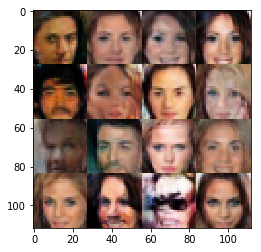

Epoch 1/1... Discriminator Loss: 1.1455... Generator Loss: 0.8750
Epoch 1/1... Discriminator Loss: 1.3973... Generator Loss: 0.6368
Epoch 1/1... Discriminator Loss: 1.3042... Generator Loss: 0.7644
Epoch 1/1... Discriminator Loss: 1.2171... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7045
Epoch 1/1... Discriminator Loss: 1.3160... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3705... Generator Loss: 0.7108
Epoch 1/1... Discriminator Loss: 1.1320... Generator Loss: 0.9407
Epoch 1/1... Discriminator Loss: 1.3612... Generator Loss: 0.8121
Epoch 1/1... Discriminator Loss: 1.1157... Generator Loss: 0.6836


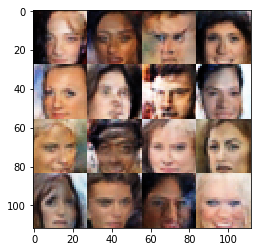

Epoch 1/1... Discriminator Loss: 1.2752... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2676... Generator Loss: 0.6548
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.5606
Epoch 1/1... Discriminator Loss: 1.4283... Generator Loss: 0.5151
Epoch 1/1... Discriminator Loss: 1.4205... Generator Loss: 0.5757
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.1868... Generator Loss: 0.7635
Epoch 1/1... Discriminator Loss: 1.3181... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4171... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.3863... Generator Loss: 0.4721


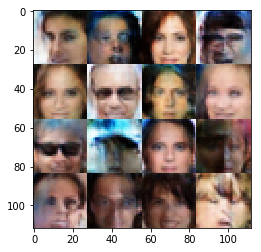

Epoch 1/1... Discriminator Loss: 1.3492... Generator Loss: 0.7112
Epoch 1/1... Discriminator Loss: 1.3496... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 1.3091... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3972... Generator Loss: 0.4726
Epoch 1/1... Discriminator Loss: 1.3503... Generator Loss: 0.8258
Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.5677
Epoch 1/1... Discriminator Loss: 1.2734... Generator Loss: 0.6899
Epoch 1/1... Discriminator Loss: 1.3671... Generator Loss: 0.6434
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.9893
Epoch 1/1... Discriminator Loss: 1.5448... Generator Loss: 0.7643


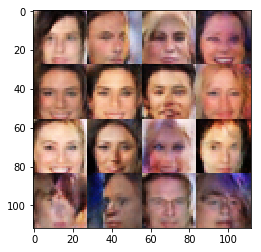

Epoch 1/1... Discriminator Loss: 1.2115... Generator Loss: 0.6093
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5748
Epoch 1/1... Discriminator Loss: 1.2188... Generator Loss: 0.6189
Epoch 1/1... Discriminator Loss: 1.3598... Generator Loss: 0.6324
Epoch 1/1... Discriminator Loss: 1.3086... Generator Loss: 0.7694
Epoch 1/1... Discriminator Loss: 1.2897... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.2474... Generator Loss: 0.6703
Epoch 1/1... Discriminator Loss: 1.4616... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4065... Generator Loss: 0.6204
Epoch 1/1... Discriminator Loss: 0.9972... Generator Loss: 1.1041


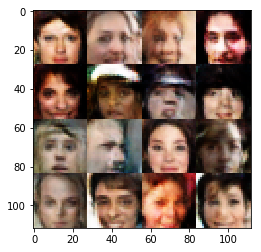

Epoch 1/1... Discriminator Loss: 1.1359... Generator Loss: 0.7700
Epoch 1/1... Discriminator Loss: 1.3333... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.3343... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2928... Generator Loss: 0.6437
Epoch 1/1... Discriminator Loss: 1.3094... Generator Loss: 0.6351
Epoch 1/1... Discriminator Loss: 1.1406... Generator Loss: 0.8692
Epoch 1/1... Discriminator Loss: 1.5327... Generator Loss: 0.7086
Epoch 1/1... Discriminator Loss: 1.2117... Generator Loss: 0.6370
Epoch 1/1... Discriminator Loss: 1.2448... Generator Loss: 0.7701
Epoch 1/1... Discriminator Loss: 1.2358... Generator Loss: 0.6386


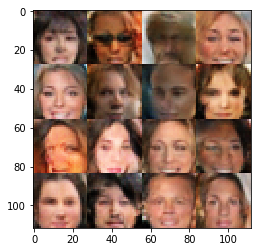

Epoch 1/1... Discriminator Loss: 1.2970... Generator Loss: 0.6468
Epoch 1/1... Discriminator Loss: 1.1624... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.2589... Generator Loss: 0.8222
Epoch 1/1... Discriminator Loss: 1.2967... Generator Loss: 0.4830
Epoch 1/1... Discriminator Loss: 1.3858... Generator Loss: 0.5041
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.5243
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 0.7674
Epoch 1/1... Discriminator Loss: 1.1676... Generator Loss: 0.8572
Epoch 1/1... Discriminator Loss: 1.3479... Generator Loss: 0.6023
Epoch 1/1... Discriminator Loss: 1.3007... Generator Loss: 0.6889


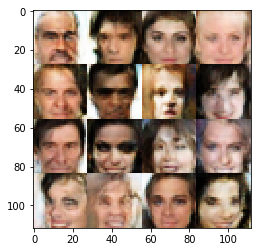

Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.7952
Epoch 1/1... Discriminator Loss: 1.4033... Generator Loss: 0.6248
Epoch 1/1... Discriminator Loss: 1.1786... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 1.1618... Generator Loss: 0.7927
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.5171
Epoch 1/1... Discriminator Loss: 1.3092... Generator Loss: 0.6878
Epoch 1/1... Discriminator Loss: 1.3981... Generator Loss: 0.6839
Epoch 1/1... Discriminator Loss: 1.3966... Generator Loss: 0.6495
Epoch 1/1... Discriminator Loss: 1.2707... Generator Loss: 0.7560
Epoch 1/1... Discriminator Loss: 1.4521... Generator Loss: 0.6103


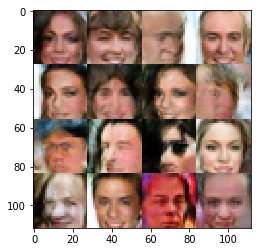

Epoch 1/1... Discriminator Loss: 1.0986... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 1.0251... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.6528... Generator Loss: 0.4038
Epoch 1/1... Discriminator Loss: 1.2008... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2925... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.5274
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.3002... Generator Loss: 0.6296


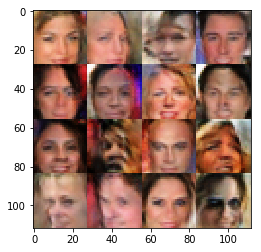

Epoch 1/1... Discriminator Loss: 1.1592... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.9385
Epoch 1/1... Discriminator Loss: 1.5716... Generator Loss: 0.6402
Epoch 1/1... Discriminator Loss: 1.3284... Generator Loss: 0.5835
Epoch 1/1... Discriminator Loss: 1.0893... Generator Loss: 0.9279
Epoch 1/1... Discriminator Loss: 1.4671... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.3262... Generator Loss: 0.8554
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.7262
Epoch 1/1... Discriminator Loss: 1.2851... Generator Loss: 0.7363
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5047


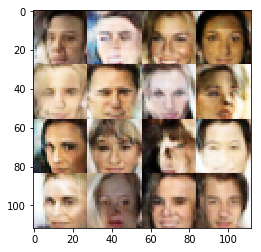

Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.6033
Epoch 1/1... Discriminator Loss: 1.3502... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1103... Generator Loss: 0.8768
Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.3776... Generator Loss: 0.8834
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.7103
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 0.5477
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.2610... Generator Loss: 0.7898
Epoch 1/1... Discriminator Loss: 1.5502... Generator Loss: 0.4331


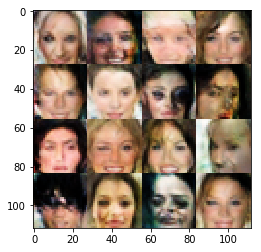

Epoch 1/1... Discriminator Loss: 1.1925... Generator Loss: 0.8123
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.5968
Epoch 1/1... Discriminator Loss: 1.3017... Generator Loss: 0.6346
Epoch 1/1... Discriminator Loss: 1.3680... Generator Loss: 0.5631
Epoch 1/1... Discriminator Loss: 1.3560... Generator Loss: 0.5729
Epoch 1/1... Discriminator Loss: 1.3573... Generator Loss: 0.7292
Epoch 1/1... Discriminator Loss: 1.1555... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7041
Epoch 1/1... Discriminator Loss: 1.2803... Generator Loss: 0.9390
Epoch 1/1... Discriminator Loss: 1.3442... Generator Loss: 0.8756


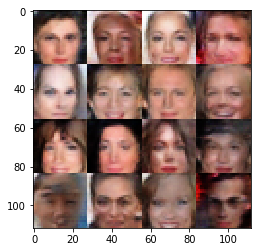

Epoch 1/1... Discriminator Loss: 1.1826... Generator Loss: 0.8094
Epoch 1/1... Discriminator Loss: 1.6344... Generator Loss: 0.5654
Epoch 1/1... Discriminator Loss: 1.1402... Generator Loss: 0.8330
Epoch 1/1... Discriminator Loss: 1.2838... Generator Loss: 0.7168
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 0.8903
Epoch 1/1... Discriminator Loss: 1.2774... Generator Loss: 0.6856
Epoch 1/1... Discriminator Loss: 1.5450... Generator Loss: 0.5054
Epoch 1/1... Discriminator Loss: 1.3563... Generator Loss: 0.7272
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 0.7277
Epoch 1/1... Discriminator Loss: 1.2900... Generator Loss: 0.8910


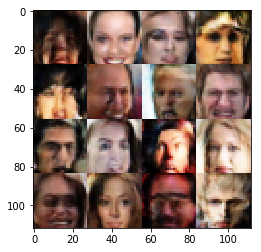

Epoch 1/1... Discriminator Loss: 1.2329... Generator Loss: 0.7695
Epoch 1/1... Discriminator Loss: 1.3069... Generator Loss: 0.6847
Epoch 1/1... Discriminator Loss: 1.3075... Generator Loss: 0.5991
Epoch 1/1... Discriminator Loss: 1.4972... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4085... Generator Loss: 0.6298
Epoch 1/1... Discriminator Loss: 1.1687... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3047... Generator Loss: 0.6317
Epoch 1/1... Discriminator Loss: 1.1759... Generator Loss: 0.8077
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.0918... Generator Loss: 0.9711


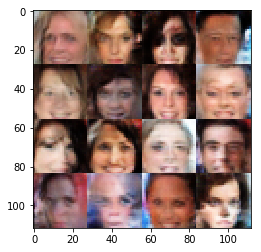

Epoch 1/1... Discriminator Loss: 1.3814... Generator Loss: 0.6478
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4842... Generator Loss: 0.5367
Epoch 1/1... Discriminator Loss: 1.1319... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 1.0254
Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.4703
Epoch 1/1... Discriminator Loss: 1.4653... Generator Loss: 0.6096
Epoch 1/1... Discriminator Loss: 1.2327... Generator Loss: 0.6686
Epoch 1/1... Discriminator Loss: 1.6899... Generator Loss: 0.4253


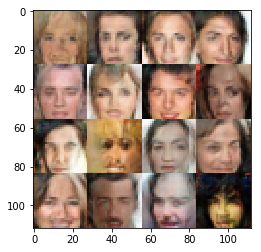

Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7140
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.2878... Generator Loss: 0.6711
Epoch 1/1... Discriminator Loss: 1.5015... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2072... Generator Loss: 0.7990
Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5645
Epoch 1/1... Discriminator Loss: 1.2953... Generator Loss: 0.6455
Epoch 1/1... Discriminator Loss: 1.1803... Generator Loss: 0.6256
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 0.8197
Epoch 1/1... Discriminator Loss: 1.1662... Generator Loss: 0.7481


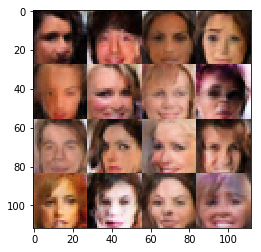

Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.3839... Generator Loss: 0.5924
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.4592
Epoch 1/1... Discriminator Loss: 1.4379... Generator Loss: 0.4772
Epoch 1/1... Discriminator Loss: 1.5615... Generator Loss: 0.5696
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.2982... Generator Loss: 0.7429
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5790
Epoch 1/1... Discriminator Loss: 1.4394... Generator Loss: 0.5690


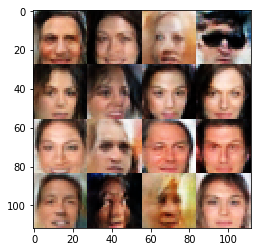

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7299
Epoch 1/1... Discriminator Loss: 1.3035... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.0901... Generator Loss: 0.8929
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.5547
Epoch 1/1... Discriminator Loss: 1.4191... Generator Loss: 0.6144
Epoch 1/1... Discriminator Loss: 1.3783... Generator Loss: 0.6998
Epoch 1/1... Discriminator Loss: 1.1944... Generator Loss: 0.7799
Epoch 1/1... Discriminator Loss: 1.4732... Generator Loss: 0.5890
Epoch 1/1... Discriminator Loss: 1.3922... Generator Loss: 0.5759
Epoch 1/1... Discriminator Loss: 1.3234... Generator Loss: 0.6230


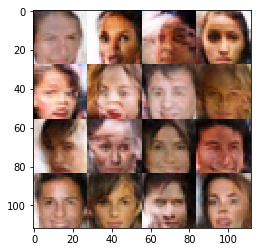

Epoch 1/1... Discriminator Loss: 1.2261... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.7982
Epoch 1/1... Discriminator Loss: 1.3311... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.2938... Generator Loss: 0.6036
Epoch 1/1... Discriminator Loss: 1.2697... Generator Loss: 0.9177
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.3876
Epoch 1/1... Discriminator Loss: 1.3138... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.9539
Epoch 1/1... Discriminator Loss: 1.4503... Generator Loss: 0.5838
Epoch 1/1... Discriminator Loss: 1.3815... Generator Loss: 0.5540


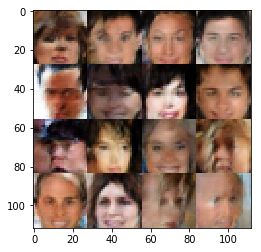

Epoch 1/1... Discriminator Loss: 1.5309... Generator Loss: 0.5102
Epoch 1/1... Discriminator Loss: 1.1437... Generator Loss: 0.7815
Epoch 1/1... Discriminator Loss: 1.3791... Generator Loss: 0.5483
Epoch 1/1... Discriminator Loss: 1.3548... Generator Loss: 0.5641
Epoch 1/1... Discriminator Loss: 1.6895... Generator Loss: 0.3987
Epoch 1/1... Discriminator Loss: 1.4748... Generator Loss: 0.6825
Epoch 1/1... Discriminator Loss: 1.6286... Generator Loss: 0.4374
Epoch 1/1... Discriminator Loss: 1.3322... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.6601
Epoch 1/1... Discriminator Loss: 1.3186... Generator Loss: 0.7738


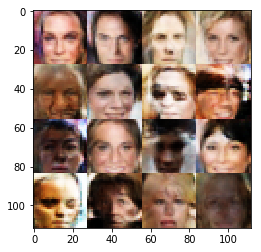

Epoch 1/1... Discriminator Loss: 1.3095... Generator Loss: 0.7094
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.6784
Epoch 1/1... Discriminator Loss: 1.2965... Generator Loss: 0.7141
Epoch 1/1... Discriminator Loss: 1.1311... Generator Loss: 1.0063
Epoch 1/1... Discriminator Loss: 1.3208... Generator Loss: 0.6049
Epoch 1/1... Discriminator Loss: 1.4279... Generator Loss: 0.6643
Epoch 1/1... Discriminator Loss: 1.1388... Generator Loss: 0.8812
Epoch 1/1... Discriminator Loss: 1.3346... Generator Loss: 0.6373
Epoch 1/1... Discriminator Loss: 1.3412... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.2505... Generator Loss: 0.6684


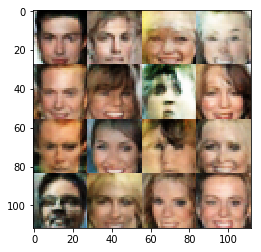

Epoch 1/1... Discriminator Loss: 1.2626... Generator Loss: 0.6867
Epoch 1/1... Discriminator Loss: 1.1258... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.5408
Epoch 1/1... Discriminator Loss: 1.5110... Generator Loss: 0.4942
Epoch 1/1... Discriminator Loss: 1.7883... Generator Loss: 0.3500
Epoch 1/1... Discriminator Loss: 1.2129... Generator Loss: 0.8542
Epoch 1/1... Discriminator Loss: 1.4973... Generator Loss: 0.5976
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.7954
Epoch 1/1... Discriminator Loss: 1.4015... Generator Loss: 0.6431
Epoch 1/1... Discriminator Loss: 1.0641... Generator Loss: 1.0063


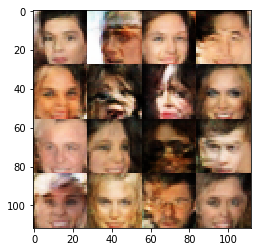

Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.6364
Epoch 1/1... Discriminator Loss: 1.3150... Generator Loss: 0.6503
Epoch 1/1... Discriminator Loss: 1.1509... Generator Loss: 0.6745
Epoch 1/1... Discriminator Loss: 1.1981... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.2586... Generator Loss: 0.7542
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.6904
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.6957
Epoch 1/1... Discriminator Loss: 1.4704... Generator Loss: 0.5714
Epoch 1/1... Discriminator Loss: 1.3344... Generator Loss: 0.6471
Epoch 1/1... Discriminator Loss: 1.1233... Generator Loss: 0.7162


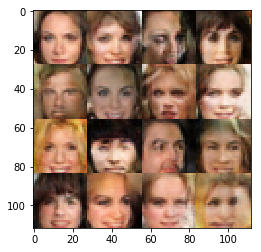

Epoch 1/1... Discriminator Loss: 1.5903... Generator Loss: 0.6516
Epoch 1/1... Discriminator Loss: 1.3251... Generator Loss: 0.7275
Epoch 1/1... Discriminator Loss: 1.3587... Generator Loss: 0.5351
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.8733
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.6571
Epoch 1/1... Discriminator Loss: 1.2371... Generator Loss: 0.8122
Epoch 1/1... Discriminator Loss: 1.1972... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 1.7197... Generator Loss: 0.4111
Epoch 1/1... Discriminator Loss: 1.3268... Generator Loss: 0.5947
Epoch 1/1... Discriminator Loss: 1.3653... Generator Loss: 0.6585


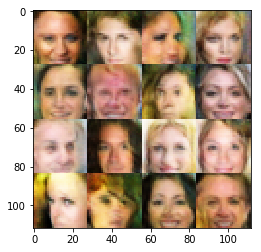

Epoch 1/1... Discriminator Loss: 1.4011... Generator Loss: 0.6165
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.6310
Epoch 1/1... Discriminator Loss: 1.3812... Generator Loss: 0.6532
Epoch 1/1... Discriminator Loss: 1.0622... Generator Loss: 0.9108
Epoch 1/1... Discriminator Loss: 1.3068... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.2294... Generator Loss: 0.7461
Epoch 1/1... Discriminator Loss: 1.4173... Generator Loss: 0.5543
Epoch 1/1... Discriminator Loss: 1.1911... Generator Loss: 0.8899
Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.6733
Epoch 1/1... Discriminator Loss: 1.4059... Generator Loss: 0.6618


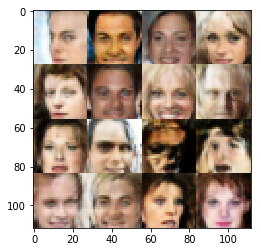

Epoch 1/1... Discriminator Loss: 1.4942... Generator Loss: 0.4988
Epoch 1/1... Discriminator Loss: 1.2464... Generator Loss: 0.8817
Epoch 1/1... Discriminator Loss: 1.3098... Generator Loss: 0.6780
Epoch 1/1... Discriminator Loss: 1.1362... Generator Loss: 0.7526
Epoch 1/1... Discriminator Loss: 1.4484... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.1237... Generator Loss: 0.7778
Epoch 1/1... Discriminator Loss: 1.4805... Generator Loss: 0.6018
Epoch 1/1... Discriminator Loss: 1.3636... Generator Loss: 0.5057
Epoch 1/1... Discriminator Loss: 1.3682... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.3983... Generator Loss: 0.5586


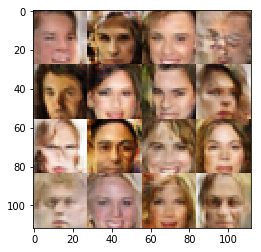

Epoch 1/1... Discriminator Loss: 1.4902... Generator Loss: 0.5540
Epoch 1/1... Discriminator Loss: 1.1918... Generator Loss: 0.6943
Epoch 1/1... Discriminator Loss: 1.3578... Generator Loss: 0.7789
Epoch 1/1... Discriminator Loss: 1.2519... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3288... Generator Loss: 0.7991
Epoch 1/1... Discriminator Loss: 1.1029... Generator Loss: 0.8935
Epoch 1/1... Discriminator Loss: 1.3327... Generator Loss: 0.7706
Epoch 1/1... Discriminator Loss: 1.3325... Generator Loss: 0.8326
Epoch 1/1... Discriminator Loss: 1.3352... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.5750... Generator Loss: 0.5805


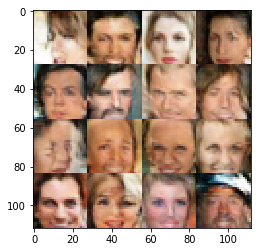

Epoch 1/1... Discriminator Loss: 1.4254... Generator Loss: 0.5554
Epoch 1/1... Discriminator Loss: 1.3101... Generator Loss: 0.5930
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.5638
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.5396
Epoch 1/1... Discriminator Loss: 1.1150... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 1.1818... Generator Loss: 0.9314
Epoch 1/1... Discriminator Loss: 1.2829... Generator Loss: 0.8189
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.7513
Epoch 1/1... Discriminator Loss: 1.2194... Generator Loss: 0.6984
Epoch 1/1... Discriminator Loss: 1.2796... Generator Loss: 0.7006


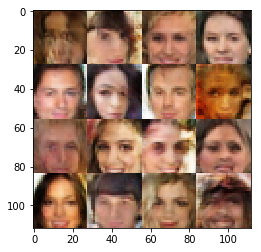

Epoch 1/1... Discriminator Loss: 1.5256... Generator Loss: 0.5324
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.9535
Epoch 1/1... Discriminator Loss: 1.2174... Generator Loss: 0.6793
Epoch 1/1... Discriminator Loss: 1.4110... Generator Loss: 0.5965
Epoch 1/1... Discriminator Loss: 1.2227... Generator Loss: 0.6646
Epoch 1/1... Discriminator Loss: 1.3167... Generator Loss: 0.7176
Epoch 1/1... Discriminator Loss: 1.5894... Generator Loss: 0.6948
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.8256
Epoch 1/1... Discriminator Loss: 1.2422... Generator Loss: 0.6308
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.6590


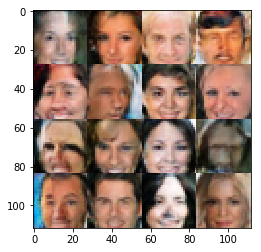

Epoch 1/1... Discriminator Loss: 1.2184... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.3174... Generator Loss: 0.5285
Epoch 1/1... Discriminator Loss: 1.1541... Generator Loss: 0.8815
Epoch 1/1... Discriminator Loss: 1.7730... Generator Loss: 0.3269
Epoch 1/1... Discriminator Loss: 1.7408... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 1.3281... Generator Loss: 0.8908
Epoch 1/1... Discriminator Loss: 1.2043... Generator Loss: 0.9064
Epoch 1/1... Discriminator Loss: 1.1748... Generator Loss: 1.0099
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.7304
Epoch 1/1... Discriminator Loss: 1.3711... Generator Loss: 0.5564


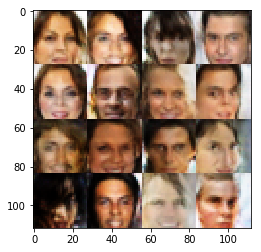

Epoch 1/1... Discriminator Loss: 1.2501... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.1335... Generator Loss: 0.8259
Epoch 1/1... Discriminator Loss: 1.1901... Generator Loss: 0.8253
Epoch 1/1... Discriminator Loss: 1.3252... Generator Loss: 0.6079
Epoch 1/1... Discriminator Loss: 1.1603... Generator Loss: 0.7742
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.7358
Epoch 1/1... Discriminator Loss: 1.3132... Generator Loss: 0.7867
Epoch 1/1... Discriminator Loss: 1.5487... Generator Loss: 0.5576
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.7023
Epoch 1/1... Discriminator Loss: 1.3405... Generator Loss: 0.5306


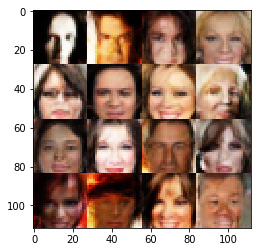

Epoch 1/1... Discriminator Loss: 1.3171... Generator Loss: 0.6269
Epoch 1/1... Discriminator Loss: 1.1397... Generator Loss: 0.7692
Epoch 1/1... Discriminator Loss: 1.3668... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.5355
Epoch 1/1... Discriminator Loss: 1.2618... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.4418... Generator Loss: 0.5413
Epoch 1/1... Discriminator Loss: 1.2057... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.2131... Generator Loss: 0.7813
Epoch 1/1... Discriminator Loss: 1.1285... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.3664... Generator Loss: 0.5647


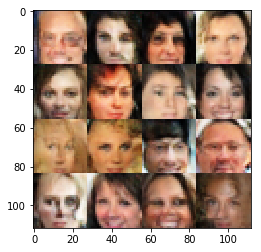

Epoch 1/1... Discriminator Loss: 1.2370... Generator Loss: 0.7028
Epoch 1/1... Discriminator Loss: 1.4348... Generator Loss: 0.5406
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.5524
Epoch 1/1... Discriminator Loss: 1.4967... Generator Loss: 0.5213
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9910
Epoch 1/1... Discriminator Loss: 1.2054... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.2850... Generator Loss: 0.8321
Epoch 1/1... Discriminator Loss: 1.1776... Generator Loss: 0.7567
Epoch 1/1... Discriminator Loss: 1.3276... Generator Loss: 0.5874
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8380


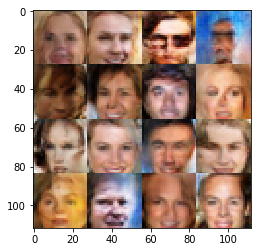

Epoch 1/1... Discriminator Loss: 1.0788... Generator Loss: 0.9268
Epoch 1/1... Discriminator Loss: 1.0856... Generator Loss: 0.7805
Epoch 1/1... Discriminator Loss: 1.3834... Generator Loss: 0.6299
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.8057
Epoch 1/1... Discriminator Loss: 1.3610... Generator Loss: 0.4904
Epoch 1/1... Discriminator Loss: 1.2407... Generator Loss: 0.7730
Epoch 1/1... Discriminator Loss: 1.2996... Generator Loss: 0.7189
Epoch 1/1... Discriminator Loss: 1.3714... Generator Loss: 0.6451
Epoch 1/1... Discriminator Loss: 1.3300... Generator Loss: 0.8215
Epoch 1/1... Discriminator Loss: 0.9875... Generator Loss: 1.1317


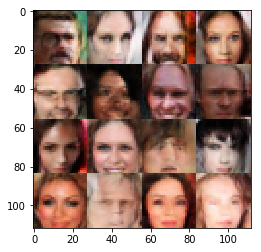

Epoch 1/1... Discriminator Loss: 1.4486... Generator Loss: 0.5239
Epoch 1/1... Discriminator Loss: 1.4108... Generator Loss: 0.4980
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.6442
Epoch 1/1... Discriminator Loss: 0.9868... Generator Loss: 1.1199
Epoch 1/1... Discriminator Loss: 1.3056... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.2962... Generator Loss: 0.7737
Epoch 1/1... Discriminator Loss: 1.3894... Generator Loss: 0.6214
Epoch 1/1... Discriminator Loss: 1.4749... Generator Loss: 0.5462
Epoch 1/1... Discriminator Loss: 1.5422... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 1.0265... Generator Loss: 0.9105


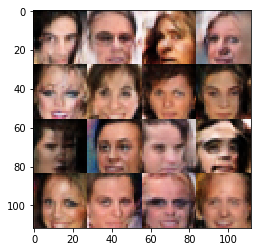

Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 1.3500... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.2861... Generator Loss: 0.8136
Epoch 1/1... Discriminator Loss: 1.4962... Generator Loss: 0.5528
Epoch 1/1... Discriminator Loss: 1.3658... Generator Loss: 0.5862
Epoch 1/1... Discriminator Loss: 1.4210... Generator Loss: 0.6072
Epoch 1/1... Discriminator Loss: 1.2565... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7372
Epoch 1/1... Discriminator Loss: 1.3874... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.2075... Generator Loss: 0.8025


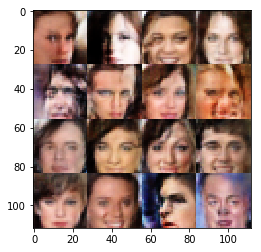

Epoch 1/1... Discriminator Loss: 1.2632... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.4583... Generator Loss: 0.5166
Epoch 1/1... Discriminator Loss: 1.1924... Generator Loss: 0.9047
Epoch 1/1... Discriminator Loss: 1.2002... Generator Loss: 0.8977
Epoch 1/1... Discriminator Loss: 1.2839... Generator Loss: 0.5985
Epoch 1/1... Discriminator Loss: 1.3878... Generator Loss: 0.7462
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 0.9215
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 0.9868
Epoch 1/1... Discriminator Loss: 1.5508... Generator Loss: 0.4797


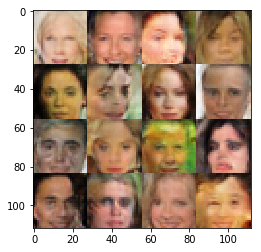

Epoch 1/1... Discriminator Loss: 1.1588... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4332... Generator Loss: 0.6637
Epoch 1/1... Discriminator Loss: 1.0317... Generator Loss: 0.8800
Epoch 1/1... Discriminator Loss: 1.3249... Generator Loss: 0.5902
Epoch 1/1... Discriminator Loss: 1.4373... Generator Loss: 0.5689
Epoch 1/1... Discriminator Loss: 1.1589... Generator Loss: 0.8527
Epoch 1/1... Discriminator Loss: 1.3685... Generator Loss: 0.5232
Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3232... Generator Loss: 0.6527


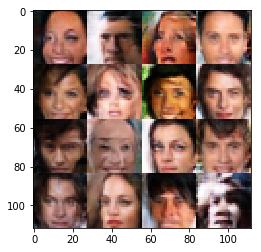

Epoch 1/1... Discriminator Loss: 1.2809... Generator Loss: 0.6974
Epoch 1/1... Discriminator Loss: 1.2769... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.3318... Generator Loss: 0.6110
Epoch 1/1... Discriminator Loss: 1.0581... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.0768... Generator Loss: 0.9057
Epoch 1/1... Discriminator Loss: 1.5427... Generator Loss: 0.4372
Epoch 1/1... Discriminator Loss: 1.2097... Generator Loss: 0.9388
Epoch 1/1... Discriminator Loss: 1.2744... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.1889... Generator Loss: 0.7625


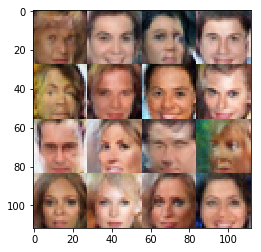

Epoch 1/1... Discriminator Loss: 1.2950... Generator Loss: 0.9484
Epoch 1/1... Discriminator Loss: 1.3241... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.8387
Epoch 1/1... Discriminator Loss: 1.1879... Generator Loss: 0.6900
Epoch 1/1... Discriminator Loss: 1.3246... Generator Loss: 0.6966
Epoch 1/1... Discriminator Loss: 1.3480... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 0.6084
Epoch 1/1... Discriminator Loss: 1.5505... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.1796... Generator Loss: 0.8673
Epoch 1/1... Discriminator Loss: 1.2490... Generator Loss: 0.7525


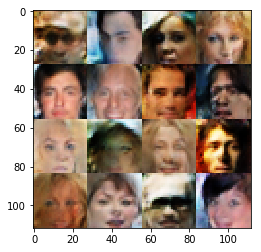

Epoch 1/1... Discriminator Loss: 1.3817... Generator Loss: 0.6866
Epoch 1/1... Discriminator Loss: 1.2087... Generator Loss: 0.8043
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7588
Epoch 1/1... Discriminator Loss: 1.2770... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.1347... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.8807
Epoch 1/1... Discriminator Loss: 1.3394... Generator Loss: 0.7421
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.7894
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6833
Epoch 1/1... Discriminator Loss: 1.3444... Generator Loss: 0.6422


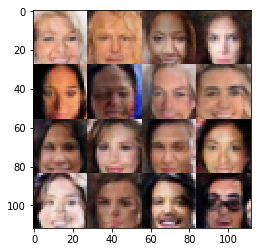

Epoch 1/1... Discriminator Loss: 1.2508... Generator Loss: 0.5956
Epoch 1/1... Discriminator Loss: 1.3298... Generator Loss: 0.6525
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.3163... Generator Loss: 0.7770
Epoch 1/1... Discriminator Loss: 1.1273... Generator Loss: 0.7817
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.6127
Epoch 1/1... Discriminator Loss: 1.5470... Generator Loss: 0.4883
Epoch 1/1... Discriminator Loss: 1.4852... Generator Loss: 0.5785
Epoch 1/1... Discriminator Loss: 1.2462... Generator Loss: 0.7508
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.8603


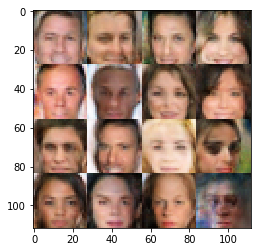

Epoch 1/1... Discriminator Loss: 1.3642... Generator Loss: 0.8457
Epoch 1/1... Discriminator Loss: 1.1586... Generator Loss: 0.7036
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.6005
Epoch 1/1... Discriminator Loss: 1.2540... Generator Loss: 0.7746
Epoch 1/1... Discriminator Loss: 1.3998... Generator Loss: 0.6055
Epoch 1/1... Discriminator Loss: 1.0678... Generator Loss: 0.8962
Epoch 1/1... Discriminator Loss: 1.4444... Generator Loss: 0.5094
Epoch 1/1... Discriminator Loss: 1.3631... Generator Loss: 0.5819
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.3728... Generator Loss: 0.8618


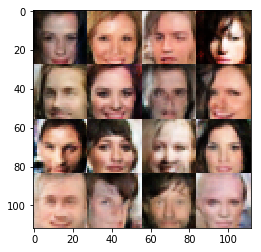

Epoch 1/1... Discriminator Loss: 1.3375... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.2763... Generator Loss: 0.7525
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.7320
Epoch 1/1... Discriminator Loss: 1.3967... Generator Loss: 0.5574
Epoch 1/1... Discriminator Loss: 1.2689... Generator Loss: 0.9127
Epoch 1/1... Discriminator Loss: 1.3468... Generator Loss: 0.5929
Epoch 1/1... Discriminator Loss: 1.1438... Generator Loss: 0.8235
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.5817
Epoch 1/1... Discriminator Loss: 1.6062... Generator Loss: 0.4834
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.5645


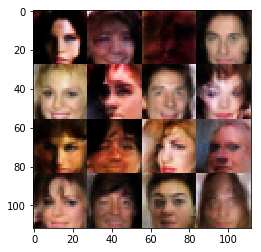

Epoch 1/1... Discriminator Loss: 1.3605... Generator Loss: 0.7774
Epoch 1/1... Discriminator Loss: 0.9922... Generator Loss: 1.0481
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 1.1746... Generator Loss: 0.8453
Epoch 1/1... Discriminator Loss: 1.2722... Generator Loss: 0.6639
Epoch 1/1... Discriminator Loss: 1.3871... Generator Loss: 0.7085
Epoch 1/1... Discriminator Loss: 1.3805... Generator Loss: 0.6371
Epoch 1/1... Discriminator Loss: 1.3857... Generator Loss: 0.5560
Epoch 1/1... Discriminator Loss: 1.2149... Generator Loss: 0.6717
Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.6632


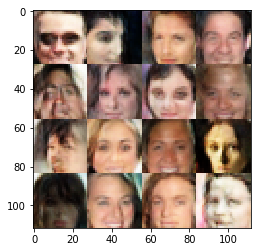

Epoch 1/1... Discriminator Loss: 1.3566... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.6099
Epoch 1/1... Discriminator Loss: 1.2555... Generator Loss: 0.7785
Epoch 1/1... Discriminator Loss: 1.4821... Generator Loss: 0.5169
Epoch 1/1... Discriminator Loss: 1.2757... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.2364... Generator Loss: 0.7818
Epoch 1/1... Discriminator Loss: 1.2214... Generator Loss: 0.5912
Epoch 1/1... Discriminator Loss: 1.4238... Generator Loss: 0.5842
Epoch 1/1... Discriminator Loss: 1.2231... Generator Loss: 0.8748
Epoch 1/1... Discriminator Loss: 1.1597... Generator Loss: 0.8934


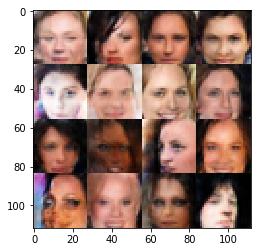

Epoch 1/1... Discriminator Loss: 1.3334... Generator Loss: 0.7466
Epoch 1/1... Discriminator Loss: 1.0719... Generator Loss: 0.6198
Epoch 1/1... Discriminator Loss: 1.2937... Generator Loss: 0.7578
Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.6731
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6449
Epoch 1/1... Discriminator Loss: 1.1321... Generator Loss: 0.8871
Epoch 1/1... Discriminator Loss: 1.4242... Generator Loss: 0.7044
Epoch 1/1... Discriminator Loss: 1.2764... Generator Loss: 0.8264
Epoch 1/1... Discriminator Loss: 1.2216... Generator Loss: 0.8096
Epoch 1/1... Discriminator Loss: 1.3376... Generator Loss: 0.6890


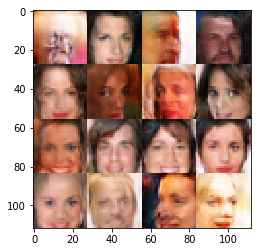

Epoch 1/1... Discriminator Loss: 1.1729... Generator Loss: 0.6854
Epoch 1/1... Discriminator Loss: 1.3657... Generator Loss: 0.7942
Epoch 1/1... Discriminator Loss: 1.5278... Generator Loss: 0.4089
Epoch 1/1... Discriminator Loss: 1.2319... Generator Loss: 0.9371
Epoch 1/1... Discriminator Loss: 1.2148... Generator Loss: 0.8567
Epoch 1/1... Discriminator Loss: 1.1433... Generator Loss: 0.8420
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.3348... Generator Loss: 0.5649
Epoch 1/1... Discriminator Loss: 1.2065... Generator Loss: 0.9393
Epoch 1/1... Discriminator Loss: 1.2465... Generator Loss: 0.6704


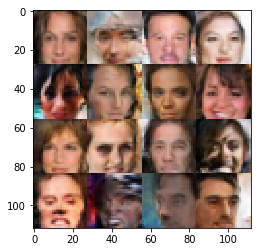

Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6742
Epoch 1/1... Discriminator Loss: 1.3363... Generator Loss: 0.7810
Epoch 1/1... Discriminator Loss: 1.4633... Generator Loss: 0.6065
Epoch 1/1... Discriminator Loss: 1.3340... Generator Loss: 0.9068
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8483
Epoch 1/1... Discriminator Loss: 1.3215... Generator Loss: 0.7670
Epoch 1/1... Discriminator Loss: 1.2966... Generator Loss: 0.6545
Epoch 1/1... Discriminator Loss: 1.2063... Generator Loss: 0.8909
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7050
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.5640


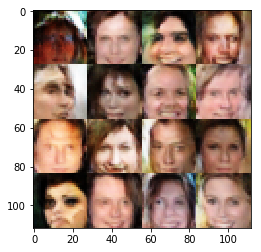

Epoch 1/1... Discriminator Loss: 1.2496... Generator Loss: 0.8407
Epoch 1/1... Discriminator Loss: 1.2569... Generator Loss: 0.6153
Epoch 1/1... Discriminator Loss: 1.3143... Generator Loss: 0.6297
Epoch 1/1... Discriminator Loss: 1.3759... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.3918... Generator Loss: 0.6779
Epoch 1/1... Discriminator Loss: 1.1872... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8936
Epoch 1/1... Discriminator Loss: 1.2339... Generator Loss: 0.9218
Epoch 1/1... Discriminator Loss: 1.1352... Generator Loss: 0.9284
Epoch 1/1... Discriminator Loss: 1.2282... Generator Loss: 0.8665


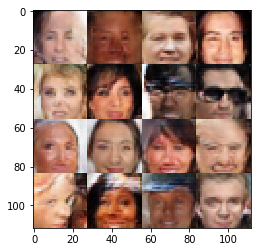

Epoch 1/1... Discriminator Loss: 1.3643... Generator Loss: 0.5493
Epoch 1/1... Discriminator Loss: 1.1439... Generator Loss: 0.6629
Epoch 1/1... Discriminator Loss: 1.2429... Generator Loss: 0.7221
Epoch 1/1... Discriminator Loss: 1.4894... Generator Loss: 0.6279
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.6439
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.7651
Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.6395
Epoch 1/1... Discriminator Loss: 1.7268... Generator Loss: 0.4667
Epoch 1/1... Discriminator Loss: 1.3202... Generator Loss: 0.8054
Epoch 1/1... Discriminator Loss: 1.1403... Generator Loss: 0.7503


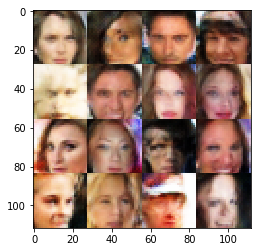

Epoch 1/1... Discriminator Loss: 1.3558... Generator Loss: 0.5922
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.6124
Epoch 1/1... Discriminator Loss: 1.2253... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.2916... Generator Loss: 0.6569
Epoch 1/1... Discriminator Loss: 1.7137... Generator Loss: 0.4679
Epoch 1/1... Discriminator Loss: 1.2156... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.5934... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.1185... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.3029... Generator Loss: 0.6482
Epoch 1/1... Discriminator Loss: 1.3022... Generator Loss: 0.7214


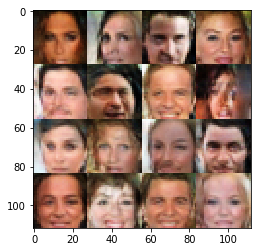

Epoch 1/1... Discriminator Loss: 1.0585... Generator Loss: 1.0135
Epoch 1/1... Discriminator Loss: 1.1663... Generator Loss: 0.8233
Epoch 1/1... Discriminator Loss: 1.2236... Generator Loss: 0.6593
Epoch 1/1... Discriminator Loss: 1.3222... Generator Loss: 0.7258
Epoch 1/1... Discriminator Loss: 1.3427... Generator Loss: 0.5698
Epoch 1/1... Discriminator Loss: 1.1947... Generator Loss: 0.7011
Epoch 1/1... Discriminator Loss: 1.1939... Generator Loss: 0.8230
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 1.0215
Epoch 1/1... Discriminator Loss: 1.2181... Generator Loss: 0.9154
Epoch 1/1... Discriminator Loss: 1.3570... Generator Loss: 0.5529


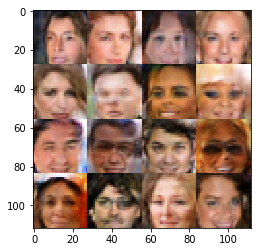

Epoch 1/1... Discriminator Loss: 1.3806... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.3940... Generator Loss: 0.4788
Epoch 1/1... Discriminator Loss: 1.2099... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3319... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.2511... Generator Loss: 0.6277
Epoch 1/1... Discriminator Loss: 1.3526... Generator Loss: 0.8008
Epoch 1/1... Discriminator Loss: 1.2578... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.2012... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.2894... Generator Loss: 0.8296
Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.6145


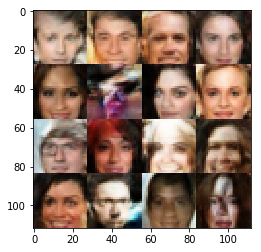

Epoch 1/1... Discriminator Loss: 1.3297... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.3899... Generator Loss: 0.6285
Epoch 1/1... Discriminator Loss: 1.1041... Generator Loss: 0.8227
Epoch 1/1... Discriminator Loss: 1.2502... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.3099... Generator Loss: 0.6748
Epoch 1/1... Discriminator Loss: 1.3689... Generator Loss: 0.5920
Epoch 1/1... Discriminator Loss: 1.3038... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.3675... Generator Loss: 0.6184
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.5910
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.9176


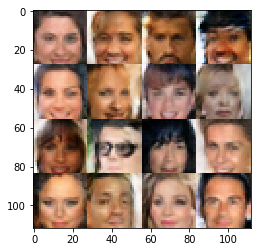

Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.7357
Epoch 1/1... Discriminator Loss: 1.2557... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4321... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 1.2529... Generator Loss: 0.5973
Epoch 1/1... Discriminator Loss: 1.3313... Generator Loss: 0.7647
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.9128


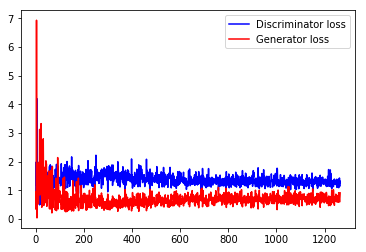

In [20]:
batch_size = 16
z_dim = 200
learning_rate = 0.0002
beta1 = 0.3



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.